<font color='#9999ff' face='Tahoma' size=6>Exploratory Data Analysis  |  Base 21 días</font>

<font face='Arial' size=3>Exploratory Data Analysis: se analiza y explora un conjunto de datos para comprender sus características, descubrir patrones, detectar anomalías, etc.</font>

<font face='Arial' size=3>Se analiza libremente basandose en principios de estadística, según los requerimientos de cada variable.</font>

***

In [1]:
import sys
sys.path.append('/workspaces/atrato-data-ds-collection-score')

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import bisect
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, f1_score, roc_curve, precision_recall_curve, auc
from sklearn.linear_model import Lasso
from xgboost import XGBClassifier
from collections import Counter
from tabulate import tabulate
import time
from joblib import Parallel, delayed

In [3]:
from tools.features import *
from tools.utils import *

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [5]:
df = pd.read_csv('../../../data_no_dvc/BASE_COLLECTION_SCORE_21_DAYS_202412031534.csv')
len(df)

68943

In [6]:
df['paid_late_commission_amount_user']

0        300.0
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
68938      NaN
68939      NaN
68940    300.0
68941      NaN
68942      NaN
Name: paid_late_commission_amount_user, Length: 68943, dtype: float64

In [7]:
del df['payment_promise_amount']
del df['payment_promise']
del df['sub7_days_delays_count']
del df['epdscore'] #Se elimina ya que se acaba de recalibrar y los clientes recurrentes ya no pasan por el flujo de donde se obtiene esta métrica

# target 60 días descartado para modelo primario
#del df['target_52_days']
#Dejo por ahora el target de 60 días para construir el target de bucket y comparar al mismo tiempo en la matriz de correlación

In [8]:
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_21_days,credito_created_at_utc
0,3649-12,3649,6135,"12,39,68,8,5,1,0",68.0,0.333,841.654671,7500.00,0.344,NaN,NaN,1.0,NaN,300.0,300.0,300.0,300.0,692.327335,NaN,18,30,Hombre,11.0,35.0,68.0,NaN,0.656,1.0,NaN,NaN,0.0,12,0,2020-08-28 18:44:51.000
1,6154-9,6154,6163,"21,-1,0,-2,31,0,2",31.0,0.167,465.000000,6000.00,0.293,B3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,461.462078,NaN,18,30,Hombre,1.0,11.0,31.0,NaN,0.707,1.0,NaN,NaN,1340.0,9,0,2020-08-28 18:57:16.000
2,9411-2,9411,6214,NaN,NaN,NaN,NaN,9000.00,NaN,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,2020-09-22 11:18:25.000
3,9411-3,9411,6214,38,38.0,0.042,528.473374,9000.00,0.029,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,0.0,0.0,38.0,NaN,0.971,1.0,NaN,NaN,0.0,2,0,2020-09-22 11:18:25.000
4,9411-12,9411,6214,"30,48,38",48.0,0.125,528.473374,9000.00,0.090,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,9.0,20.0,48.0,NaN,0.910,1.0,NaN,NaN,0.0,6,1,2020-09-22 11:18:25.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68938,1784040-2,1784040,245527,0,NaN,NaN,NaN,2500.00,0.310,B3,A1,3.0,NaN,NaN,NaN,NaN,NaN,960.350000,NaN,3,33,Hombre,NaN,NaN,NaN,NaN,0.690,3.0,73.0,OxxoPay,NaN,2,0,2024-08-17 15:59:43.000
68939,1798971-1,1798971,557315,NaN,NaN,NaN,NaN,12000.00,0.083,B2,C2,3.0,NaN,NaN,NaN,NaN,NaN,1846.280000,NaN,9,49,Hombre,NaN,NaN,NaN,NaN,0.917,2.0,12.0,OxxoPay,0.0,1,0,2024-08-22 22:27:20.000
68940,1808066-1,1808066,529536,NaN,13.0,0.167,8520.000000,39000.00,0.139,B1,C1,3.0,1.0,300.0,300.0,300.0,300.0,8220.800000,NaN,6,30,Mujer,1.0,1.0,13.0,NaN,0.861,2.0,84.0,NaN,3366.0,1,0,2024-08-29 15:27:12.000
68941,1829021-1,1829021,673669,NaN,NaN,NaN,NaN,8490.00,NaN,C1,B2,1.0,NaN,600.0,NaN,NaN,NaN,1076.720000,NaN,12,21,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,0.0,1,0,2024-09-11 00:23:44.000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68943 entries, 0 to 68942
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   idobservation                        68943 non-null  object 
 1   id_solicitud                         68943 non-null  int64  
 2   id_userv3                            68943 non-null  int64  
 3   payment_history                      61260 non-null  object 
 4   max_overdue                          47745 non-null  float64
 5   ratio_overdue_payments               47745 non-null  float64
 6   max_overdue_amount                   47772 non-null  float64
 7   granted_credit_amount                68943 non-null  float64
 8   pct_credit_maturity                  65297 non-null  float64
 9   risk_profile_v1                      68721 non-null  object 
 10  risk_profile_v2                      65832 non-null  object 
 11  num_atrato_credits          

## Calculo de las variables del payment history

In [10]:
df_con_payment_history = df[~df['payment_history'].isna()]

In [11]:
resultados = df_con_payment_history.groupby('id_userv3').apply(aplicar_funciones_por_solicitud).reset_index(drop=True)

/tmp/ipykernel_46742/2826079949.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resultados = df_con_payment_history.groupby('id_userv3').apply(aplicar_funciones_por_solicitud).reset_index(drop=True)


In [12]:
resultados

,id_solicitud,idobservation,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
0,92492,92492-5,6.000,6.000000,1,1.000000,0,0,0,0,0
1,205798,205798-3,0.000,0.000000,1,0.500000,0,0,0,0,0
2,205798,205798-7,-7.500,12.888889,1,0.333333,2,3,1,2,1
3,205798,205798-6,-5.625,9.666667,1,0.187500,1,3,1,1,1
4,205798,205798-2,0.000,0.000000,1,0.200000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
61255,1825397,1825397-2,0.000,0.000000,0,0.000000,0,0,0,0,0
61256,1825437,1825437-2,0.000,0.000000,1,1.000000,0,0,0,1,0
61257,1825639,1825639-2,0.000,0.000000,0,0.000000,0,0,0,0,0
61258,1848202,1848202-2,0.000,0.000000,1,1.000000,0,0,0,1,0


Se juntan los dataframes:

In [13]:
df = pd.merge(df, resultados.iloc[:,1:], how='left', on='idobservation')
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_21_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
0,3649-12,3649,6135,"12,39,68,8,5,1,0",68.0,0.333,841.654671,7500.00,0.344,NaN,NaN,1.0,NaN,300.0,300.0,300.0,300.0,692.327335,NaN,18,30,Hombre,11.0,35.0,68.0,NaN,0.656,1.0,NaN,NaN,0.0,12,0,2020-08-28 18:44:51.000,2.5,24.666667,1.0,0.830,2.0,2.0,2.0,1.0,1.0
1,6154-9,6154,6163,"21,-1,0,-2,31,0,2",31.0,0.167,465.000000,6000.00,0.293,B3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,461.462078,NaN,18,30,Hombre,1.0,11.0,31.0,NaN,0.707,1.0,NaN,NaN,1340.0,9,0,2020-08-28 18:57:16.000,-12.0,7.000000,1.0,2.000,2.0,1.0,0.0,2.0,0.0
2,9411-2,9411,6214,NaN,NaN,NaN,NaN,9000.00,NaN,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,2020-09-22 11:18:25.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9411-3,9411,6214,38,38.0,0.042,528.473374,9000.00,0.029,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,0.0,0.0,38.0,NaN,0.971,1.0,NaN,NaN,0.0,2,0,2020-09-22 11:18:25.000,0.0,0.000000,1.0,1.000,0.0,0.0,0.0,1.0,0.0
4,9411-12,9411,6214,"30,48,38",48.0,0.125,528.473374,9000.00,0.090,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,9.0,20.0,48.0,NaN,0.910,1.0,NaN,NaN,0.0,6,1,2020-09-22 11:18:25.000,0.0,0.000000,1.0,0.335,0.0,0.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68938,1784040-2,1784040,245527,0,NaN,NaN,NaN,2500.00,0.310,B3,A1,3.0,NaN,NaN,NaN,NaN,NaN,960.350000,NaN,3,33,Hombre,NaN,NaN,NaN,NaN,0.690,3.0,73.0,OxxoPay,NaN,2,0,2024-08-17 15:59:43.000,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0
68939,1798971-1,1798971,557315,NaN,NaN,NaN,NaN,12000.00,0.083,B2,C2,3.0,NaN,NaN,NaN,NaN,NaN,1846.280000,NaN,9,49,Hombre,NaN,NaN,NaN,NaN,0.917,2.0,12.0,OxxoPay,0.0,1,0,2024-08-22 22:27:20.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68940,1808066-1,1808066,529536,NaN,13.0,0.167,8520.000000,39000.00,0.139,B1,C1,3.0,1.0,300.0,300.0,300.0,300.0,8220.800000,NaN,6,30,Mujer,1.0,1.0,13.0,NaN,0.861,2.0,84.0,NaN,3366.0,1,0,2024-08-29 15:27:12.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68941,1829021-1,1829021,673669,NaN,NaN,NaN,NaN,8490.00,NaN,C1,B2,1.0,NaN,600.0,NaN,NaN,NaN,1076.720000,NaN,12,21,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,0.0,1,0,2024-09-11 00:23:44.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***

## <font color='#8789ed' face='Tahoma' size=5> Correlation Chart </font>

<font face='Arial' size=3>Mapa de correlaciones de todas las variables de modelo</font>

<font face='Arial' size=3>Por ahora se excluyen algunas columnas</font>

- <font face='Arial' size=3><font face='Monaco' size=3>payment_history</font> (es array)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>credito_created_at_utc</font> (es fecha)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>most_used_paymentmethod</font> (es categorico)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>risk_profile_v1</font> (es categorico)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>risk_profile_v2</font> (es categorico)</font>
- <font face='Arial' size=3><font face='Monaco' size=3>gender</font> (es categorico)</font>
- [...]

In [14]:
df_corr = df.copy()

#df_corr = df_corr[~(df_corr['payment_history'].isna())]

del df_corr['payment_history']
del df_corr['credito_created_at_utc']
del df_corr['most_used_paymentmethod']
del df_corr['risk_profile_v1']
del df_corr['risk_profile_v2']
del df_corr['gender']
del df_corr['has_mortgage_or_large_loans']
del df_corr['id_solicitud']
del df_corr['id_userv3']
del df_corr['idobservation']


In [15]:
df_corr.shape

(68943, 33)

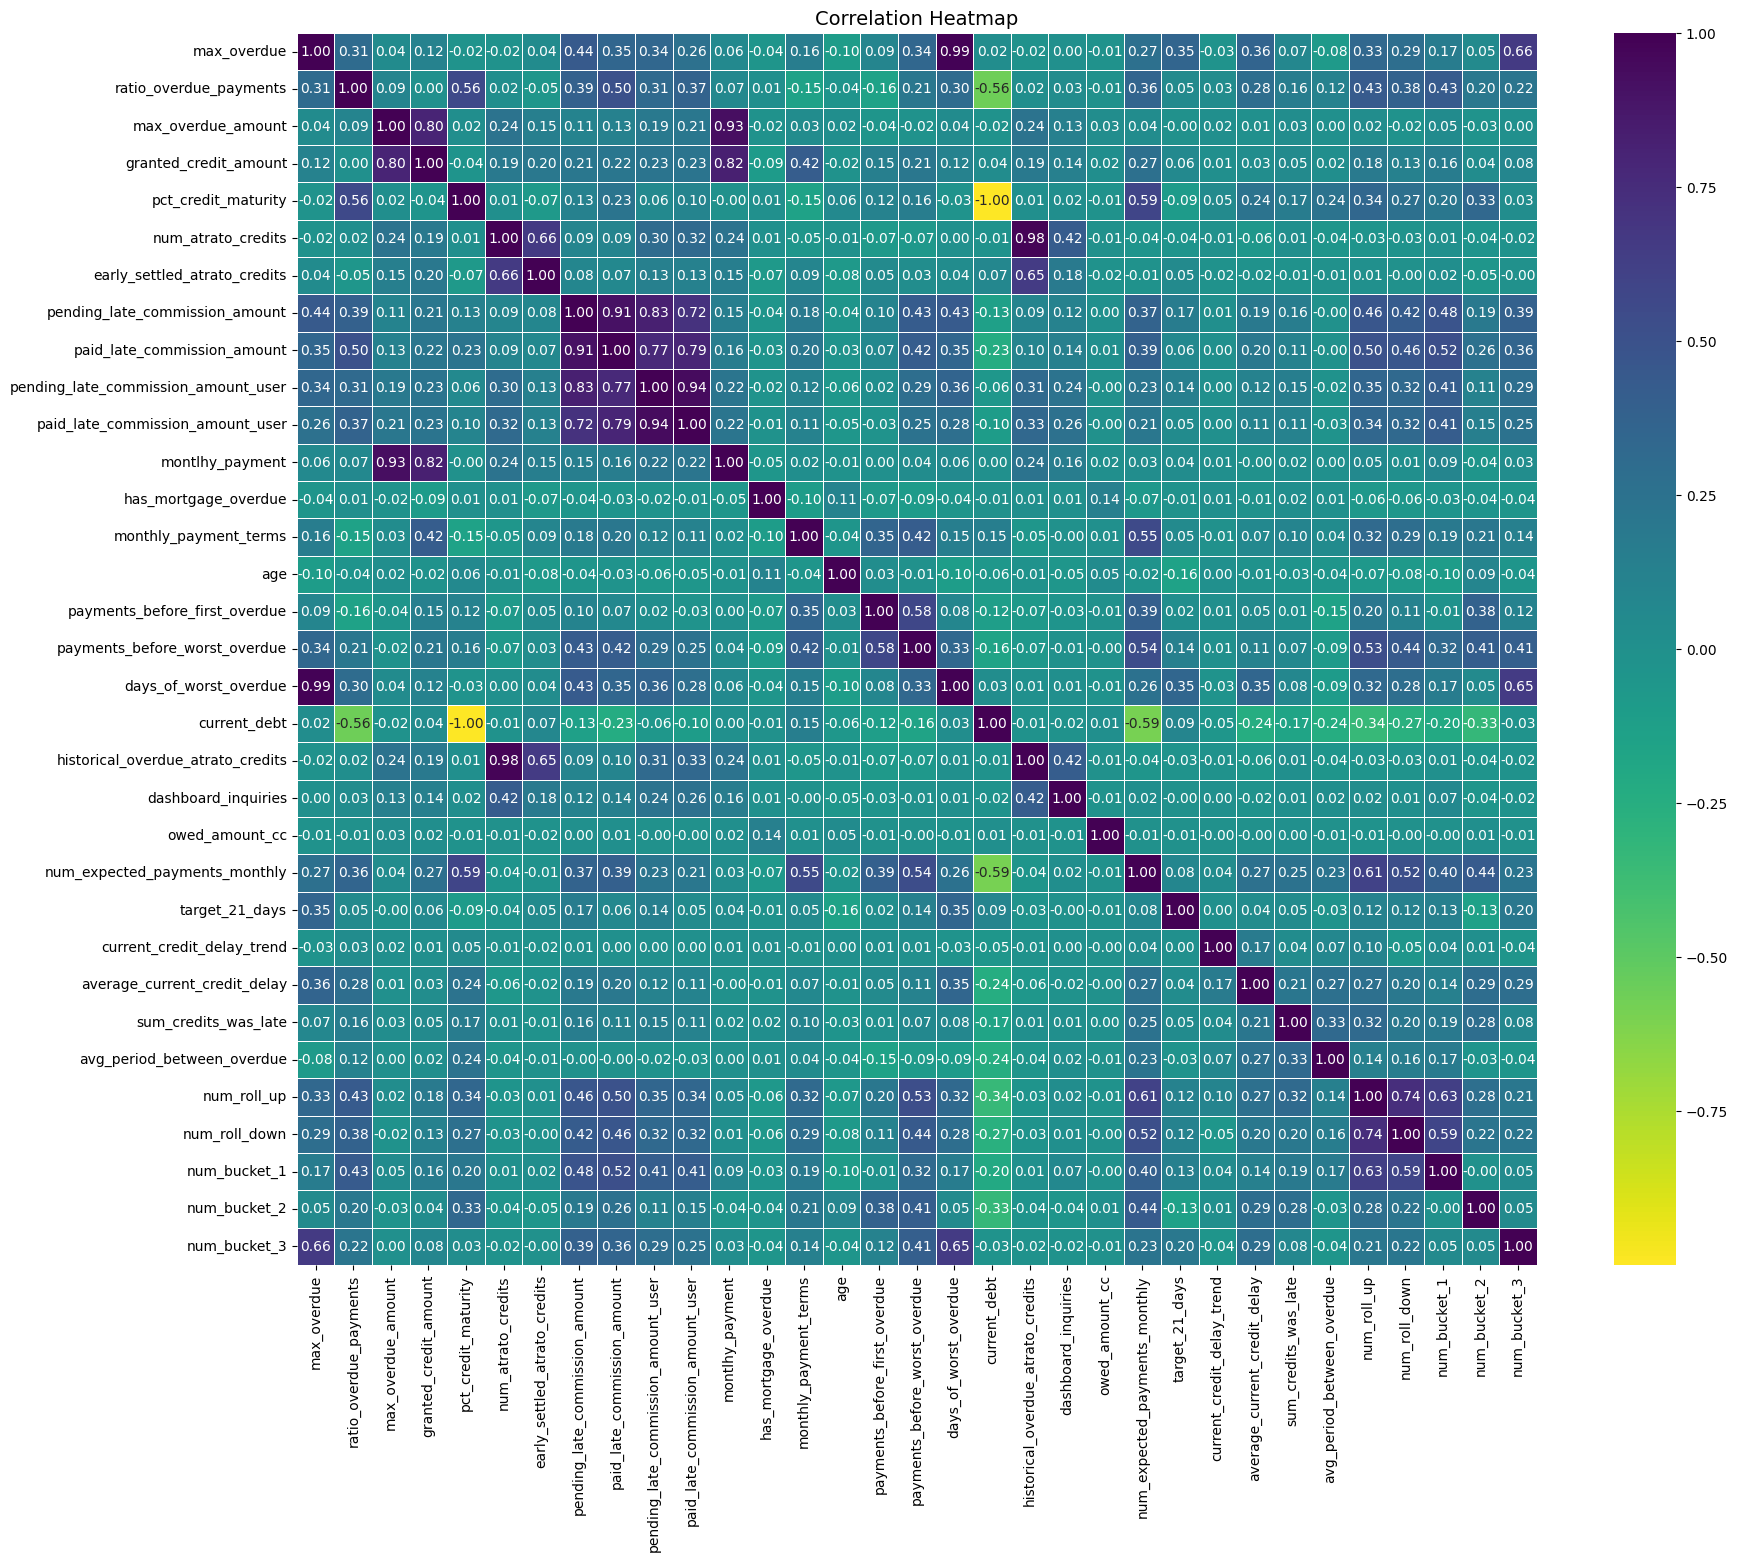

In [16]:
plt.figure(figsize=(20, 16))  
plt.title('Correlation Heatmap', fontsize=14)

sns.heatmap(df_corr.corr(), annot=True, 
            fmt=".2f",  # Limita a dos decimales
            cmap='viridis_r', linecolor='white', linewidths=0.5, 
            annot_kws={"size": 10}  # size font annot
            )

plt.xticks(rotation=90, fontsize=10) 
plt.yticks(fontsize=10)
plt.show()


***

## <font color='#8789ed' face='Tahoma' size=5>Exploración de variables</font> 

<font face='Arial' size=3>Es importante tomar en cuenta que por ahora se pueden hacer dos aproximaciones:</font> 

1. <font face='Arial' size=3>Cada registro que entre al entrenamiento corresponde a un usuario.</font> 
2. <font face='Arial' size=3>Cada registro que entra al entrenamiento corresponde a un crédito.</font> 


In [17]:
len(df)

68943

In [18]:
# hacemos un df de solo los que tienen payment_hist con valor
#df = df[~(df['payment_history'].isna())]
len(df)


68943

In [19]:
df['target_21_days'].value_counts()

target_21_days
0    51522
1    17421
Name: count, dtype: int64

In [20]:
df['target_21_days'].value_counts(normalize=True)

target_21_days
0    0.747313
1    0.252687
Name: proportion, dtype: float64

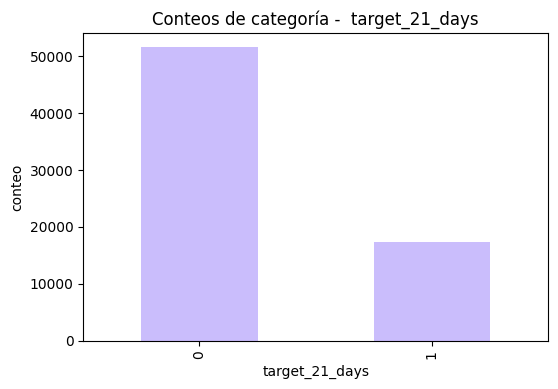

In [21]:
plt.figure(figsize=(6, 4))
df['target_21_days'].value_counts().plot(kind='bar' , color='#cabdfc')
plt.title(f'Conteos de categoría -  {'target_21_days'}')
plt.xlabel('target_21_days')
plt.ylabel('conteo')
plt.xticks(rotation=90)
plt.show()

In [22]:
# id_userv3 es el usuario que llega a hacer solicitud (un solo user puede tener varios idsolicitud)
df['id_userv3'].unique().shape

(22215,)

In [23]:
df['num_atrato_credits'].value_counts()

num_atrato_credits
1.0     40773
2.0     16135
3.0      7182
4.0      2894
5.0      1267
6.0       409
7.0       162
8.0        58
10.0       16
9.0        13
15.0        2
11.0        2
12.0        1
Name: count, dtype: int64

In [24]:
# 2 observaciones tienen hasta 15 créditos
df[df['num_atrato_credits']==15]

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_21_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
37099,1537261-6,1537261,2426,"0,-1,2,0,0",2.0,0.083,1000.0,3500.0,0.071,C3,A1,15.0,12.0,NaN,NaN,580.42,580.42,703.08,NaN,6,34,Hombre,4.0,7.0,2.0,NaN,0.929,15.0,300.0,Conekta-STP,283.0,3,1,2024-03-01 14:36:16.000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
37100,1537261-7,1537261,2426,"0,-1,2,0,0",2.0,0.083,1000.0,3500.0,0.071,C3,A1,15.0,12.0,NaN,NaN,580.42,580.42,703.08,NaN,6,34,Hombre,5.0,6.0,2.0,NaN,0.929,15.0,307.0,NaN,283.0,4,1,2024-03-01 14:36:16.000,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_21_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
0,3649-12,3649,6135,"12,39,68,8,5,1,0",68.0,0.333,841.654671,7500.00,0.344,NaN,NaN,1.0,NaN,300.0,300.0,300.0,300.0,692.327335,NaN,18,30,Hombre,11.0,35.0,68.0,NaN,0.656,1.0,NaN,NaN,0.0,12,0,2020-08-28 18:44:51.000,2.5,24.666667,1.0,0.830,2.0,2.0,2.0,1.0,1.0
1,6154-9,6154,6163,"21,-1,0,-2,31,0,2",31.0,0.167,465.000000,6000.00,0.293,B3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,461.462078,NaN,18,30,Hombre,1.0,11.0,31.0,NaN,0.707,1.0,NaN,NaN,1340.0,9,0,2020-08-28 18:57:16.000,-12.0,7.000000,1.0,2.000,2.0,1.0,0.0,2.0,0.0
2,9411-2,9411,6214,NaN,NaN,NaN,NaN,9000.00,NaN,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,2020-09-22 11:18:25.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9411-3,9411,6214,38,38.0,0.042,528.473374,9000.00,0.029,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,0.0,0.0,38.0,NaN,0.971,1.0,NaN,NaN,0.0,2,0,2020-09-22 11:18:25.000,0.0,0.000000,1.0,1.000,0.0,0.0,0.0,1.0,0.0
4,9411-12,9411,6214,"30,48,38",48.0,0.125,528.473374,9000.00,0.090,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,9.0,20.0,48.0,NaN,0.910,1.0,NaN,NaN,0.0,6,1,2020-09-22 11:18:25.000,0.0,0.000000,1.0,0.335,0.0,0.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68938,1784040-2,1784040,245527,0,NaN,NaN,NaN,2500.00,0.310,B3,A1,3.0,NaN,NaN,NaN,NaN,NaN,960.350000,NaN,3,33,Hombre,NaN,NaN,NaN,NaN,0.690,3.0,73.0,OxxoPay,NaN,2,0,2024-08-17 15:59:43.000,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0
68939,1798971-1,1798971,557315,NaN,NaN,NaN,NaN,12000.00,0.083,B2,C2,3.0,NaN,NaN,NaN,NaN,NaN,1846.280000,NaN,9,49,Hombre,NaN,NaN,NaN,NaN,0.917,2.0,12.0,OxxoPay,0.0,1,0,2024-08-22 22:27:20.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68940,1808066-1,1808066,529536,NaN,13.0,0.167,8520.000000,39000.00,0.139,B1,C1,3.0,1.0,300.0,300.0,300.0,300.0,8220.800000,NaN,6,30,Mujer,1.0,1.0,13.0,NaN,0.861,2.0,84.0,NaN,3366.0,1,0,2024-08-29 15:27:12.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68941,1829021-1,1829021,673669,NaN,NaN,NaN,NaN,8490.00,NaN,C1,B2,1.0,NaN,600.0,NaN,NaN,NaN,1076.720000,NaN,12,21,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,0.0,1,0,2024-09-11 00:23:44.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
features_list = list(df.columns)
features_list.remove('id_solicitud')
features_list.remove('id_userv3')
features_list.remove('idobservation')
features_list.remove('target_21_days')
features_list.remove('credito_created_at_utc')
features_list

['payment_history',
 'max_overdue',
 'ratio_overdue_payments',
 'max_overdue_amount',
 'granted_credit_amount',
 'pct_credit_maturity',
 'risk_profile_v1',
 'risk_profile_v2',
 'num_atrato_credits',
 'early_settled_atrato_credits',
 'pending_late_commission_amount',
 'paid_late_commission_amount',
 'pending_late_commission_amount_user',
 'paid_late_commission_amount_user',
 'montlhy_payment',
 'has_mortgage_overdue',
 'monthly_payment_terms',
 'age',
 'gender',
 'payments_before_first_overdue',
 'payments_before_worst_overdue',
 'days_of_worst_overdue',
 'has_mortgage_or_large_loans',
 'current_debt',
 'historical_overdue_atrato_credits',
 'dashboard_inquiries',
 'most_used_paymentmethod',
 'owed_amount_cc',
 'num_expected_payments_monthly',
 'current_credit_delay_trend',
 'average_current_credit_delay',
 'sum_credits_was_late',
 'avg_period_between_overdue',
 'num_roll_up',
 'num_roll_down',
 'num_bucket_1',
 'num_bucket_2',
 'num_bucket_3']

In [27]:
len(features_list)

38

***
## <font color='#78acf0' face='Optima' size=5>Numeric Features</font> 

<font face='Arial' size=3>Establecemos una lista de las features numéricas para analizarlas en conjunto en la generalidad e ir revisando a detalle cada una. Este nuevo dataset nos permite generar gráficas usando una función y así observar qué variables pueden ser conflictivas.</font> 




In [28]:
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_21_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
0,3649-12,3649,6135,"12,39,68,8,5,1,0",68.0,0.333,841.654671,7500.00,0.344,NaN,NaN,1.0,NaN,300.0,300.0,300.0,300.0,692.327335,NaN,18,30,Hombre,11.0,35.0,68.0,NaN,0.656,1.0,NaN,NaN,0.0,12,0,2020-08-28 18:44:51.000,2.5,24.666667,1.0,0.830,2.0,2.0,2.0,1.0,1.0
1,6154-9,6154,6163,"21,-1,0,-2,31,0,2",31.0,0.167,465.000000,6000.00,0.293,B3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,461.462078,NaN,18,30,Hombre,1.0,11.0,31.0,NaN,0.707,1.0,NaN,NaN,1340.0,9,0,2020-08-28 18:57:16.000,-12.0,7.000000,1.0,2.000,2.0,1.0,0.0,2.0,0.0
2,9411-2,9411,6214,NaN,NaN,NaN,NaN,9000.00,NaN,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,2020-09-22 11:18:25.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9411-3,9411,6214,38,38.0,0.042,528.473374,9000.00,0.029,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,0.0,0.0,38.0,NaN,0.971,1.0,NaN,NaN,0.0,2,0,2020-09-22 11:18:25.000,0.0,0.000000,1.0,1.000,0.0,0.0,0.0,1.0,0.0
4,9411-12,9411,6214,"30,48,38",48.0,0.125,528.473374,9000.00,0.090,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,9.0,20.0,48.0,NaN,0.910,1.0,NaN,NaN,0.0,6,1,2020-09-22 11:18:25.000,0.0,0.000000,1.0,0.335,0.0,0.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68938,1784040-2,1784040,245527,0,NaN,NaN,NaN,2500.00,0.310,B3,A1,3.0,NaN,NaN,NaN,NaN,NaN,960.350000,NaN,3,33,Hombre,NaN,NaN,NaN,NaN,0.690,3.0,73.0,OxxoPay,NaN,2,0,2024-08-17 15:59:43.000,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0
68939,1798971-1,1798971,557315,NaN,NaN,NaN,NaN,12000.00,0.083,B2,C2,3.0,NaN,NaN,NaN,NaN,NaN,1846.280000,NaN,9,49,Hombre,NaN,NaN,NaN,NaN,0.917,2.0,12.0,OxxoPay,0.0,1,0,2024-08-22 22:27:20.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68940,1808066-1,1808066,529536,NaN,13.0,0.167,8520.000000,39000.00,0.139,B1,C1,3.0,1.0,300.0,300.0,300.0,300.0,8220.800000,NaN,6,30,Mujer,1.0,1.0,13.0,NaN,0.861,2.0,84.0,NaN,3366.0,1,0,2024-08-29 15:27:12.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68941,1829021-1,1829021,673669,NaN,NaN,NaN,NaN,8490.00,NaN,C1,B2,1.0,NaN,600.0,NaN,NaN,NaN,1076.720000,NaN,12,21,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,0.0,1,0,2024-09-11 00:23:44.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
numeric_features = ['max_overdue','ratio_overdue_payments','max_overdue_amount','granted_credit_amount','pct_credit_maturity',
                    'num_atrato_credits','early_settled_atrato_credits','pending_late_commission_amount',
                    'paid_late_commission_amount','pending_late_commission_amount_user','paid_late_commission_amount_user',
                    'montlhy_payment','monthly_payment_terms','age','payments_before_first_overdue',
                    'payments_before_worst_overdue','days_of_worst_overdue','current_debt','historical_overdue_atrato_credits',
                    'dashboard_inquiries','owed_amount_cc','num_expected_payments_monthly','current_credit_delay_trend',
                    'average_current_credit_delay','sum_credits_was_late','avg_period_between_overdue',
                    'num_roll_up','num_roll_down','num_bucket_1','num_bucket_2','num_bucket_3',]

numeric_features

['max_overdue',
 'ratio_overdue_payments',
 'max_overdue_amount',
 'granted_credit_amount',
 'pct_credit_maturity',
 'num_atrato_credits',
 'early_settled_atrato_credits',
 'pending_late_commission_amount',
 'paid_late_commission_amount',
 'pending_late_commission_amount_user',
 'paid_late_commission_amount_user',
 'montlhy_payment',
 'monthly_payment_terms',
 'age',
 'payments_before_first_overdue',
 'payments_before_worst_overdue',
 'days_of_worst_overdue',
 'current_debt',
 'historical_overdue_atrato_credits',
 'dashboard_inquiries',
 'owed_amount_cc',
 'num_expected_payments_monthly',
 'current_credit_delay_trend',
 'average_current_credit_delay',
 'sum_credits_was_late',
 'avg_period_between_overdue',
 'num_roll_up',
 'num_roll_down',
 'num_bucket_1',
 'num_bucket_2',
 'num_bucket_3']

In [30]:
len(numeric_features)

31

In [31]:
df_numeric = df[numeric_features]
df_numeric


,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
0,68.0,0.333,841.654671,7500.00,0.344,1.0,NaN,300.0,300.0,300.0,300.0,692.327335,18,30,11.0,35.0,68.0,0.656,1.0,NaN,0.0,12,2.5,24.666667,1.0,0.830,2.0,2.0,2.0,1.0,1.0
1,31.0,0.167,465.000000,6000.00,0.293,1.0,NaN,NaN,NaN,NaN,NaN,461.462078,18,30,1.0,11.0,31.0,0.707,1.0,NaN,1340.0,9,-12.0,7.000000,1.0,2.000,2.0,1.0,0.0,2.0,0.0
2,NaN,NaN,NaN,9000.00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,12,23,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,38.0,0.042,528.473374,9000.00,0.029,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,12,23,0.0,0.0,38.0,0.971,1.0,NaN,0.0,2,0.0,0.000000,1.0,1.000,0.0,0.0,0.0,1.0,0.0
4,48.0,0.125,528.473374,9000.00,0.090,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,12,23,9.0,20.0,48.0,0.910,1.0,NaN,0.0,6,0.0,0.000000,1.0,0.335,0.0,0.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68938,NaN,NaN,NaN,2500.00,0.310,3.0,NaN,NaN,NaN,NaN,NaN,960.350000,3,33,NaN,NaN,NaN,0.690,3.0,73.0,NaN,2,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0
68939,NaN,NaN,NaN,12000.00,0.083,3.0,NaN,NaN,NaN,NaN,NaN,1846.280000,9,49,NaN,NaN,NaN,0.917,2.0,12.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68940,13.0,0.167,8520.000000,39000.00,0.139,3.0,1.0,300.0,300.0,300.0,300.0,8220.800000,6,30,1.0,1.0,13.0,0.861,2.0,84.0,3366.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68941,NaN,NaN,NaN,8490.00,NaN,1.0,NaN,600.0,NaN,NaN,NaN,1076.720000,12,21,NaN,NaN,NaN,NaN,NaN,16.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <font color='sky blue' face='Optima' size=4>Correlation Chart</font> 


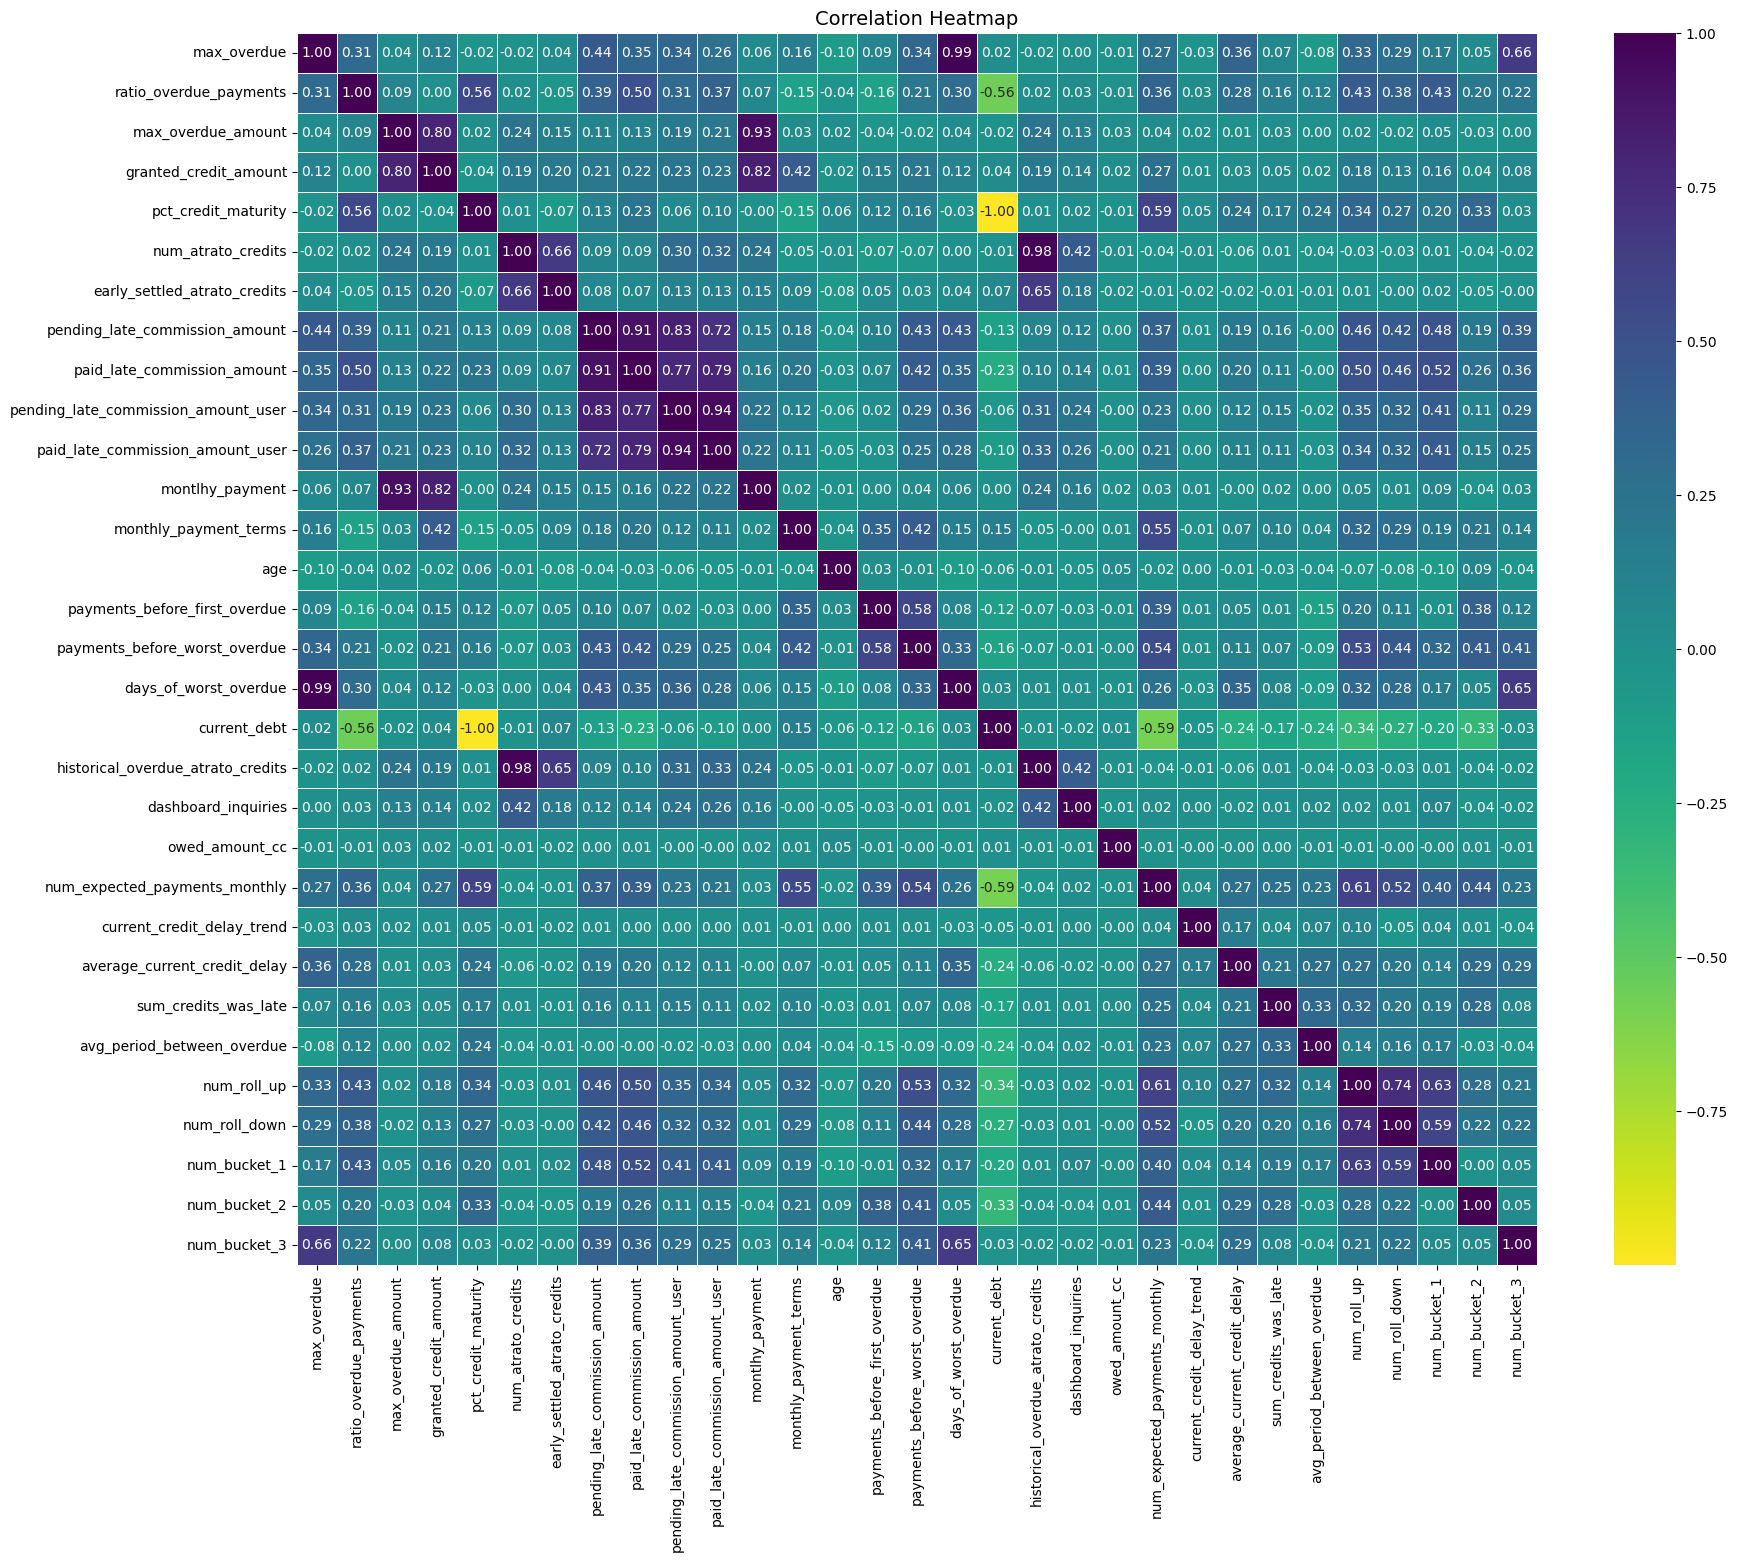

In [32]:
plt.figure(figsize=(20, 16))  
plt.title('Correlation Heatmap', fontsize=14)

sns.heatmap(df_numeric.corr(), annot=True, 
            fmt=".2f",  # 2 decimales
            cmap='viridis_r', linecolor='white', linewidths=0.5, 
            annot_kws={"size": 10}  # size font annot
            )

plt.xticks(rotation=90, fontsize=10) 
plt.yticks(fontsize=10)
plt.show()

### <font color='sky blue' face='Optima' size=4>Numeric Cols Null Volume</font> 


In [33]:
get_missing_report(df_numeric)

,columns,missingPercentage,type
6,early_settled_atrato_credits,86.784735,float64
8,paid_late_commission_amount,51.928405,float64
10,paid_late_commission_amount_user,45.064764,float64
7,pending_late_commission_amount,42.117401,float64
9,pending_late_commission_amount_user,39.953295,float64
0,max_overdue,30.747139,float64
16,days_of_worst_overdue,30.747139,float64
1,ratio_overdue_payments,30.747139,float64
14,payments_before_first_overdue,30.707976,float64
15,payments_before_worst_overdue,30.707976,float64


### <font color='sky blue' face='Optima' size=4>Numeric Cols Distribution</font> 


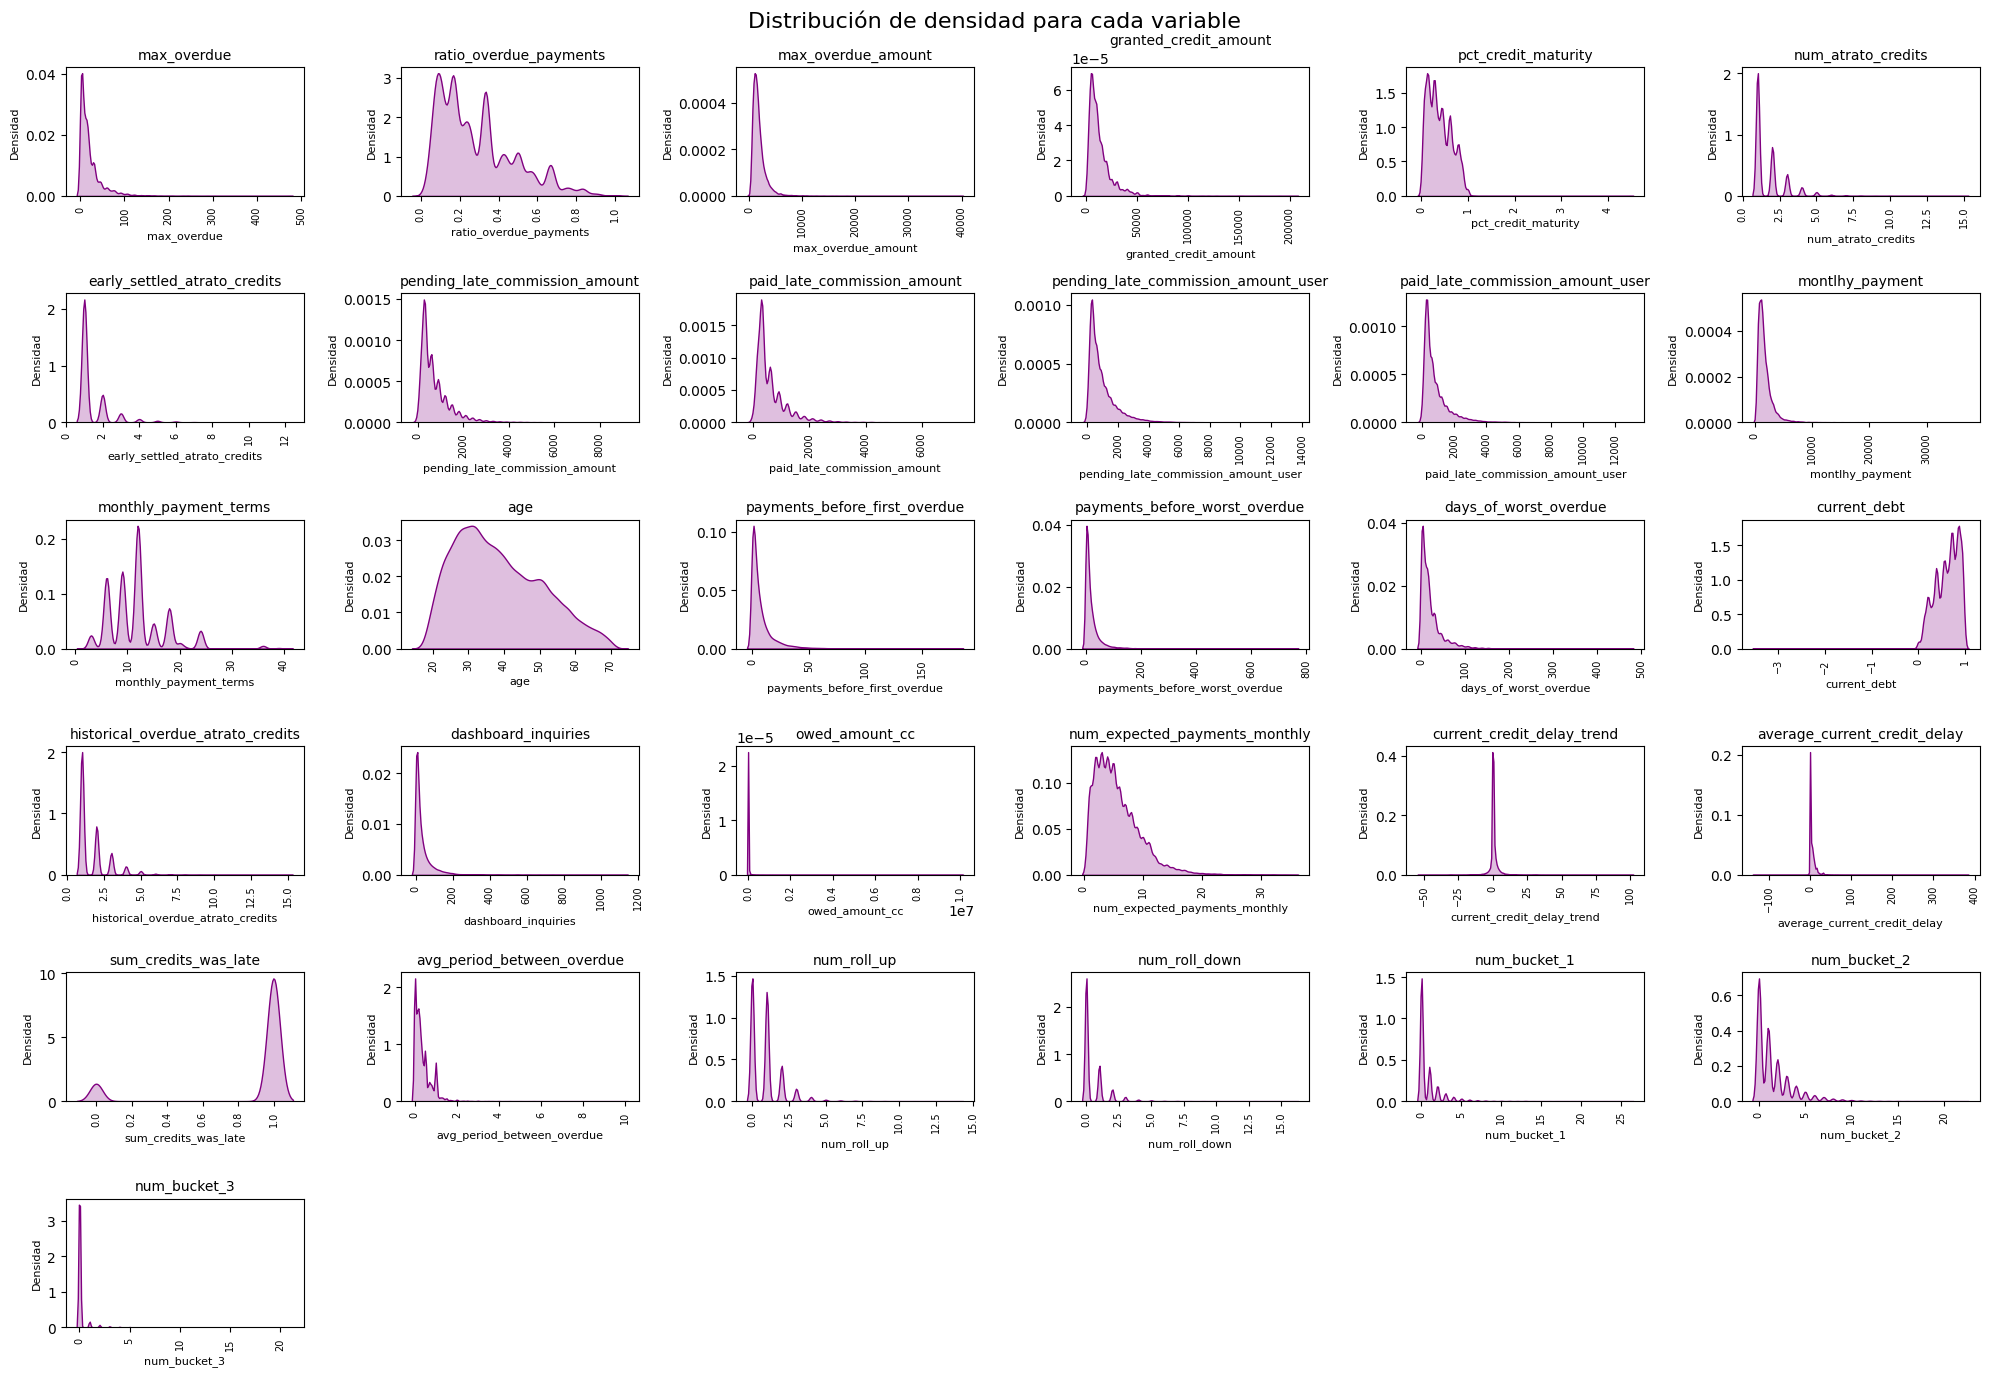

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

n_cols = 6
n_rows = 6

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 14)) 
fig.suptitle('Distribución de densidad para cada variable', fontsize=16)
axes = axes.flatten() 
for i, col in enumerate(df_numeric.columns):
    sns.kdeplot(data=df_numeric, x=col, color='purple', fill=True, ax=axes[i])
    axes[i].set_title(f'{col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Densidad', fontsize=8)
    axes[i].tick_params(axis='x', rotation=90, labelsize=7)

# Oculta cualquier subfigura vacía 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### <font color='#b33b3b' face='Monaco' size=5>max_overdue</font> 

<font face='Arial' size=3>Máximo número de días atrasado (actual crédito)</font> 

<font face='Arial' size=3>Los montos negativos representan que pagó ese número de días antes de su fecha</font> 



In [35]:
df_numeric['max_overdue'].describe()

count    47745.000000
mean        20.950571
std         26.770851
min          1.000000
25%          3.000000
50%         13.000000
75%         28.000000
max        473.000000
Name: max_overdue, dtype: float64

In [36]:
len(df_numeric[df_numeric['max_overdue']<1])/len(df_numeric)*100

0.0

In [37]:
# iqr para determinar 'normalidad'
IQR = df_numeric['max_overdue'].describe()[6]-df_numeric['max_overdue'].describe()[4]
rango = [df_numeric['max_overdue'].describe()[4]-IQR*1.5, df_numeric['max_overdue'].describe()[6]+IQR*1.5]
print(rango)

[-34.5, 65.5]


/tmp/ipykernel_46742/1354835366.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['max_overdue'].describe()[6]-df_numeric['max_overdue'].describe()[4]
/tmp/ipykernel_46742/1354835366.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['max_overdue'].describe()[6]-df_numeric['max_overdue'].describe()[4]
/tmp/ipykernel_46742/1354835366.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rango = [df_

<font face='Arial' size=3>Consideramos normal de 1 (mínimo) a 65 días de atraso</font> 

<font face='Arial' size=3>Revisión de atrasados más de 65 dias</font> 



In [38]:
# cantidad de registros con atraso mayor a 65 dias
len(df_numeric[df_numeric['max_overdue']>65])

3195

In [39]:
# proporción de registros con atraso mayor a 65 dias
len(df_numeric[df_numeric['max_overdue']>65]) / len(df_numeric)*100

4.634263086897872

In [40]:
# media de días de atraso en mayor a 65 dias
df_numeric[df_numeric['max_overdue']>65]['max_overdue'].mean()

97.82660406885759

In [41]:
# máximo de días de atraso en mayor a 65 dias
df_numeric[df_numeric['max_overdue']>65]['max_overdue'].max()

473.0

In [42]:
# mínimo de días de atraso en mayor a 65 dias
df_numeric[df_numeric['max_overdue']>65]['max_overdue'].min()

66.0

In [43]:
df_numeric[df_numeric['max_overdue']>65]['max_overdue'].describe()

count    3195.000000
mean       97.826604
std        35.325138
min        66.000000
25%        75.000000
50%        88.000000
75%       108.000000
max       473.000000
Name: max_overdue, dtype: float64

In [44]:
len(df_numeric[df_numeric['max_overdue']>108])

769

In [45]:
len(df_numeric[df_numeric['max_overdue']>108])/len(df_numeric)*100

1.1154141827306614

<font face='Arial' size=3>No hay máximo días de atraso < 0</font> 


#### <font color='#b33b3b' face='Monaco' size=5>days_of_worst_overdue</font> 

<font face='Arial' size=3>Número de días de su peor atraso (de este crédito para atrás, incluye crédito actual pero no última parcialidad pagada)</font> 

<font face='Arial' size=3>Winner vs. max_overdue</font> 


<font face='Arial' size=3>Los montos negativos representan que pagó ese número de días antes de su fecha</font> 



In [46]:
df_numeric['days_of_worst_overdue'].describe()

count    47745.000000
mean        21.493622
std         26.899186
min          1.000000
25%          4.000000
50%         13.000000
75%         29.000000
max        473.000000
Name: days_of_worst_overdue, dtype: float64

In [47]:
len(df_numeric[df_numeric['days_of_worst_overdue']<1])/len(df_numeric)*100

0.0

In [48]:
# iqr para determinar 'normalidad'
IQR = df_numeric['days_of_worst_overdue'].describe()[6]-df_numeric['days_of_worst_overdue'].describe()[4]
rango = [df_numeric['days_of_worst_overdue'].describe()[4]-IQR*1.5, df_numeric['days_of_worst_overdue'].describe()[6]+IQR*1.5]
print(rango)

[-33.5, 66.5]


/tmp/ipykernel_46742/3668458543.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['days_of_worst_overdue'].describe()[6]-df_numeric['days_of_worst_overdue'].describe()[4]
/tmp/ipykernel_46742/3668458543.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['days_of_worst_overdue'].describe()[6]-df_numeric['days_of_worst_overdue'].describe()[4]
/tmp/ipykernel_46742/3668458543.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

<font face='Arial' size=3>Consideramos normal de 1 (minimo) a 66 días del peor atraso</font> 

<font face='Arial' size=3>Revisión de atrasos máximos de más de 66 dias</font> 



In [49]:
# cantidad de registros con atraso máximo mayor a 66 dias
len(df_numeric[df_numeric['days_of_worst_overdue']>66])

3193

In [50]:
# proporción de registros con atraso máximo mayor a 66 dias
len(df_numeric[df_numeric['days_of_worst_overdue']>66]) / len(df_numeric)*100

4.631362139738624

In [51]:
# media de días de atraso máximo mayor a 66 dias
df_numeric[df_numeric['days_of_worst_overdue']>66]['days_of_worst_overdue'].mean()

98.47979956154087

In [52]:
# máximo de días de atraso máximo mayor a 66 dias
df_numeric[df_numeric['days_of_worst_overdue']>66]['days_of_worst_overdue'].max()

473.0

In [53]:
# mínimo de días de atraso máximo mayor a 66 dias
df_numeric[df_numeric['days_of_worst_overdue']>66]['days_of_worst_overdue'].min()

67.0

In [54]:
df_numeric[df_numeric['days_of_worst_overdue']>66]['days_of_worst_overdue'].describe()

count    3193.000000
mean       98.479800
std        35.063883
min        67.000000
25%        76.000000
50%        89.000000
75%       108.000000
max       473.000000
Name: days_of_worst_overdue, dtype: float64

In [55]:
len(df_numeric[df_numeric['days_of_worst_overdue']>108])

775

In [56]:
len(df_numeric[df_numeric['days_of_worst_overdue']>108])/len(df_numeric)*100

1.124117024208404

<font face='Arial' size=3>No hay atrasos < 0 , en esta población no hay usuarios que tienen como peor atraso un pago anticipado.</font> 


#### <font color='#b33b3b' face='Monaco' size=5>ratio_overdue_payments</font> 

<font face='Arial' size=3>Periodos entre atrasos, veces que se atrasó / número de parcialidades del crédito actual</font> 




In [57]:
df_numeric['ratio_overdue_payments'].describe()

count    47745.000000
mean         0.286756
std          0.192724
min          0.021000
25%          0.125000
50%          0.250000
75%          0.417000
max          1.000000
Name: ratio_overdue_payments, dtype: float64

In [58]:
df_numeric['ratio_overdue_payments'].isnull().sum()

21198

In [59]:
df_numeric['ratio_overdue_payments'].isnull().sum()/len(df)*100

30.747138940864193

In [60]:
len(df_numeric[df_numeric['ratio_overdue_payments']>1])

0

In [61]:
len(df_numeric[df_numeric['ratio_overdue_payments']>1])/len(df_numeric)*100

0.0

#### <font color='#b33b3b' face='Monaco' size=5>max_overdue_amount</font> 

<font face='Arial' size=3>Máximo monto atrasado, este incluye la suma de comisiones, intereses moratorios, etc...</font> 

In [62]:
df_numeric['max_overdue_amount'].describe()

count    47772.000000
mean      1719.499299
std       1330.425250
min         13.350000
25%        915.000000
50%       1387.500000
75%       2086.450000
max      39865.096509
Name: max_overdue_amount, dtype: float64

In [63]:
# proporción de casos que tienen adeudo  máximo arriba de 2500
len(df_numeric[df_numeric['max_overdue_amount']>2500])/len(df_numeric)*100

11.743034100633858

In [64]:
# proporción de casos que tienen adeudo  máximo arriba de 5000
len(df_numeric[df_numeric['max_overdue_amount']>5000])/len(df_numeric)*100

1.8087405537908128

In [65]:
# iqr para determinar 'normalidad'
IQR = df_numeric['max_overdue_amount'].describe()[6]-df_numeric['max_overdue_amount'].describe()[4]
rango = [df_numeric['max_overdue_amount'].describe()[4]-IQR*1.5, df_numeric['max_overdue_amount'].describe()[6]+IQR*1.5]
print(rango)

[-842.1750000000004, 3843.625000000001]


/tmp/ipykernel_46742/4068100413.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['max_overdue_amount'].describe()[6]-df_numeric['max_overdue_amount'].describe()[4]
/tmp/ipykernel_46742/4068100413.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['max_overdue_amount'].describe()[6]-df_numeric['max_overdue_amount'].describe()[4]
/tmp/ipykernel_46742/4068100413.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

In [66]:
# proporción d ecasos que tienen adeudo  máximo arriba de 3,843 (límite superior de IQR)
len(df_numeric[df_numeric['max_overdue_amount']>3843])/len(df_numeric)*100

4.078731705901977

<font face='Arial' size=3>Consideramos normal de 13.35 (mínimo) a 3,843 el monto de su máximo atraso</font> 

<font face='Arial' size=3>Revisión de montos mayores a 3,840.495 como máximo atraso</font> 



In [67]:
# cantidad de registros con monto máximo de atraso mayor a 3,843
len(df_numeric[df_numeric['max_overdue_amount']>3843])

2812

In [68]:
# cantidad de registros con monto máximo de atraso mayor a 3,843
len(df_numeric[df_numeric['max_overdue_amount']>3843])/ len(df_numeric)*100

4.078731705901977

In [69]:
# media de monto en registros con monto máximo de atraso mayor a 3,843
df_numeric[df_numeric['max_overdue_amount']>3843]['max_overdue_amount'].mean()

5558.591286925445

In [70]:
# máximo de monto en registros con monto máximo de atraso mayor a 3,843
df_numeric[df_numeric['max_overdue_amount']>3843]['max_overdue_amount'].max()

39865.09650917904

In [71]:
# mínimo de monto en registros con monto máximo de atraso mayor a 3,843
df_numeric[df_numeric['max_overdue_amount']>3843]['max_overdue_amount'].min()

3844.27

In [72]:
df_numeric[df_numeric['max_overdue_amount']>3843]['max_overdue_amount'].describe()

count     2812.000000
mean      5558.591287
std       2150.112153
min       3844.270000
25%       4250.000000
50%       4844.460000
75%       6025.000000
max      39865.096509
Name: max_overdue_amount, dtype: float64

In [73]:
len(df_numeric[df_numeric['max_overdue_amount']>6025])

701

In [74]:
len(df_numeric[df_numeric['max_overdue_amount']>6025])/len(df_numeric)*100

1.0167819793162467

<font face='Arial' size=3>Revisión montos arriba de 6,025</font> 


In [75]:
# cantidad de registros con monto máximo de peor atraso arriba de 6,025
len(df_numeric[df_numeric['max_overdue_amount']>6025])

701

In [76]:
# proporción de registros con monto máximo de peor atraso arriba de 6,025
len(df_numeric[df_numeric['max_overdue_amount']>6025])/ len(df_numeric) *100

1.0167819793162467

In [77]:
# media de monto en registros con monto máximo de peor atraso arriba de 6,025
df_numeric[df_numeric['max_overdue_amount']>6025]['max_overdue_amount'].mean()

8304.59202911631

In [78]:
# mínimo de monto en registros con monto máximo de peor atraso arriba de 6,025
df_numeric[df_numeric['max_overdue_amount']>6025]['max_overdue_amount'].min()

6033.299999999999

In [79]:
# máximo de monto en registros con monto máximo de peor atraso arriba de 6,025
df_numeric[df_numeric['max_overdue_amount']>6025]['max_overdue_amount'].max()

39865.09650917904

In [80]:
df_numeric[df_numeric['max_overdue_amount']>6025]['max_overdue_amount'].describe()

count      701.000000
mean      8304.592029
std       2712.690117
min       6033.300000
25%       6687.240000
50%       7604.000000
75%       8847.060000
max      39865.096509
Name: max_overdue_amount, dtype: float64

In [81]:
comp = pd.DataFrame()
comp['max_overdue_amount'] = df_numeric['max_overdue_amount']
comp['granted_credit_amount'] = df_numeric['granted_credit_amount']
comp['montlhy_payment'] = df_numeric['montlhy_payment']
comp

,max_overdue_amount,granted_credit_amount,montlhy_payment
0,841.654671,7500.00,692.327335
1,465.000000,6000.00,461.462078
2,NaN,9000.00,1056.946749
3,528.473374,9000.00,1056.946749
4,528.473374,9000.00,1056.946749
...,...,...,...
68938,NaN,2500.00,960.350000
68939,NaN,12000.00,1846.280000
68940,8520.000000,39000.00,8220.800000
68941,NaN,8490.00,1076.720000


In [82]:
# si es mayor a 1, debe más de 1 parcialidad , ratio de cuántamos mensualidades fueron su max cantidad atrasada
comp['max_overdue_amount_over_montlhy_payment']=comp['max_overdue_amount']/comp['montlhy_payment']

# sí puede ser mayor a 1, por suma de comisiones e intereses 
comp['max_overdue_amount_over_granted_amount']=comp['max_overdue_amount']/comp['granted_credit_amount']

comp

,max_overdue_amount,granted_credit_amount,montlhy_payment,max_overdue_amount_over_montlhy_payment,max_overdue_amount_over_granted_amount
0,841.654671,7500.00,692.327335,1.215689,0.112221
1,465.000000,6000.00,461.462078,1.007667,0.077500
2,NaN,9000.00,1056.946749,NaN,NaN
3,528.473374,9000.00,1056.946749,0.500000,0.058719
4,528.473374,9000.00,1056.946749,0.500000,0.058719
...,...,...,...,...,...
68938,NaN,2500.00,960.350000,NaN,NaN
68939,NaN,12000.00,1846.280000,NaN,NaN
68940,8520.000000,39000.00,8220.800000,1.036395,0.218462
68941,NaN,8490.00,1076.720000,NaN,NaN


In [83]:
len(comp[comp['max_overdue_amount_over_montlhy_payment']>1])

30775

In [84]:
len(comp[comp['max_overdue_amount_over_montlhy_payment']>1])/len(comp)*100

44.638324412920824

<font face='Arial' size=3>Para el 44.6717% de los usuarios su peor monto de atraso fue mayor que el monto correspondiente a solo 1 mensualidad.</font> 

In [85]:
len(comp[comp['max_overdue_amount_over_granted_amount']>1])

1

In [86]:
len(comp[comp['max_overdue_amount_over_granted_amount']>1])/len(comp)*100

0.001450473579623747

In [87]:
len(comp[comp['max_overdue_amount_over_granted_amount']>1])

1

<font face='Arial' size=3>No hay usuarios que su peor monto de atraso fue mayor que el monto total otorgado (usuarios que pagan de más)</font> 

#### <font color='#b33b3b' face='Monaco' size=5>granted_credit_amount</font> 

<font face='Arial' size=3>Monto del crédito otorgado.</font> 

In [88]:
df_numeric['granted_credit_amount'].describe()

count     68943.000000
mean      13147.112275
std       12597.352110
min          99.000000
25%        5000.000000
50%       10000.000000
75%       16199.000000
max      204582.650000
Name: granted_credit_amount, dtype: float64

<font face='Arial' size=3>Crédito de monto mínimo de 99 pesos fue de: 2022-09-24 13:03:21 en GAIA DESIGN</font> 

In [89]:
# conteo de usuarios que tienen granted_amount mayor a 16,199 que es el 3er cuartil
len(df_numeric[df_numeric['granted_credit_amount']>16199])

17235

In [90]:
# iqr para determinar 'normalidad'
IQR = df_numeric['granted_credit_amount'].describe()[6]-df_numeric['granted_credit_amount'].describe()[4]
rango = [df_numeric['granted_credit_amount'].describe()[4]-IQR*1.5, df_numeric['granted_credit_amount'].describe()[6]+IQR*1.5]
print(rango)

[-11798.5, 32997.5]


/tmp/ipykernel_46742/2871101407.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['granted_credit_amount'].describe()[6]-df_numeric['granted_credit_amount'].describe()[4]
/tmp/ipykernel_46742/2871101407.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['granted_credit_amount'].describe()[6]-df_numeric['granted_credit_amount'].describe()[4]
/tmp/ipykernel_46742/2871101407.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

<font face='Arial' size=3>Rango de normalidad va de 99 (mínimo) a 32,997.50 </font> 

<font face='Arial' size=3>Revisión de casos mayor a 32,997.50 </font> 


In [91]:
# cantidad de registros con monto otorgado mayor a 32,997.5
len(df_numeric[df_numeric['granted_credit_amount']>32997.5])

4576

In [92]:
# proporción de registros con monto otorgado mayor a 32,997.5
len(df_numeric[df_numeric['granted_credit_amount']>32997.5]) / len(df_numeric)*100

6.637367100358267

In [93]:
# media de monto otorgado entre créditos fuera de límite superior de normalidad 
df_numeric[df_numeric['granted_credit_amount']>32997.5]['granted_credit_amount'].mean()

48419.69307036713

In [94]:
# máximo de monto otorgano entre créditos fuera de límite superior de normalidad 
df_numeric[df_numeric['granted_credit_amount']>32997.5]['granted_credit_amount'].max()

204582.65

In [95]:
# mínimo de monto otorgano entre créditos fuera de límite superior de normalidad 
df_numeric[df_numeric['granted_credit_amount']>32997.5]['granted_credit_amount'].min()

32998.0

In [96]:
df_numeric[df_numeric['granted_credit_amount']>32997.5]['granted_credit_amount'].describe()

count      4576.000000
mean      48419.693070
std       18281.658084
min       32998.000000
25%       37500.000000
50%       42497.000000
75%       50000.000000
max      204582.650000
Name: granted_credit_amount, dtype: float64

In [97]:
df.groupby('risk_profile_v1')['granted_credit_amount'].mean()

risk_profile_v1
       8000.000000
A1    21445.593553
A2    20940.791455
A3    13471.700726
B1    16078.806216
B2    12654.519800
B3     9073.849043
C1     7416.470912
C2     8894.902481
C3     8184.548195
Name: granted_credit_amount, dtype: float64

In [98]:
df.groupby('risk_profile_v2')['granted_credit_amount'].mean()

risk_profile_v2
A1    13935.159555
A2    16363.954391
B1    14508.116885
B2    12646.532870
C1    12209.885780
C2    11666.460688
D1    11117.686096
Name: granted_credit_amount, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>pct_credit_maturity</font> 

<font face='Arial' size=3>Porcentaje de avance en su crédito.  (n° cuotas pagadas / totales ) </font> 

<font color='cyan' face='Tahoma' size=3>NOTA</font><font face='Arial' size=3> : casos mayor a 1, se eliminan de TRAIN.</font>


In [99]:
df_numeric['pct_credit_maturity'].describe()

count    65297.000000
mean         0.387375
std          0.248125
min          0.000000
25%          0.173000
50%          0.343000
75%          0.588000
max          4.468000
Name: pct_credit_maturity, dtype: float64

In [100]:
len(df_numeric[df_numeric['pct_credit_maturity']>1])

107

In [101]:
len(df_numeric[df_numeric['pct_credit_maturity']>1])/len(df)*100

0.15520067301974094

In [102]:
# iqr para determinar 'normalidad'
IQR = df_numeric['pct_credit_maturity'].describe()[6]-df_numeric['pct_credit_maturity'].describe()[4]
rango = [df_numeric['pct_credit_maturity'].describe()[4]-IQR*1.5, df_numeric['pct_credit_maturity'].describe()[6]+IQR*1.5]
print(rango)

[-0.44949999999999996, 1.2105]


/tmp/ipykernel_46742/1085572007.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pct_credit_maturity'].describe()[6]-df_numeric['pct_credit_maturity'].describe()[4]
/tmp/ipykernel_46742/1085572007.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pct_credit_maturity'].describe()[6]-df_numeric['pct_credit_maturity'].describe()[4]
/tmp/ipykernel_46742/1085572007.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, us

<font face='Arial' size=3>Revisión de casos mayor a 1 --> usuarios que siguen pagando sin saber que ya quedó pagada la totalidad de las parcialidades</font> 


In [103]:
# cantidad de registros con madurez mayor a 1
len(df_numeric[df_numeric['pct_credit_maturity']>1])

107

In [104]:
# proporción de registros con madurez mayor a 1
len(df_numeric[df_numeric['pct_credit_maturity']>1]) / len(df_numeric)*100

0.15520067301974094

In [105]:
df_numeric[df_numeric['pct_credit_maturity']>1]['pct_credit_maturity'].describe()

count    107.000000
mean       1.072084
std        0.336976
min        1.001000
25%        1.002000
50%        1.013000
75%        1.061500
max        4.468000
Name: pct_credit_maturity, dtype: float64

<font face='Arial' size=3>**pct_credit_maturity>1**</font>

<font face='Arial' size=3>no debe ser >=1</font>



In [106]:
df[df['pct_credit_maturity']>1]

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_21_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
656,114905-25,114905,47553,"0,-1,-3,-3,0,-1,-2,-3,3,0,0,-1,-3,-3,-2,-1,0,0...",3.0,0.067,500.00,10649.00,1.005,B1,C2,2.0,NaN,NaN,NaN,NaN,NaN,847.62,NaN,15,34,Hombre,5.0,15.0,3.0,NaN,-0.005,2.0,NaN,BBVA Practicaja,0.0,12,0,2021-11-13 20:36:20.000,1.5,-0.428571,1.0,5.000,0.0,0.0,0.0,0.0,0.0
1327,47599-11,47599,1936,"0,0,-1,-2,0,-2,1,0,0,0",1.0,0.083,400.00,2940.00,1.017,C1,B2,1.0,NaN,NaN,NaN,NaN,NaN,375.09,NaN,12,36,Hombre,3.0,3.0,1.0,NaN,-0.017,1.0,NaN,OxxoPay,0.0,11,0,2021-08-16 20:12:52.000,1.0,0.000000,1.0,0.000,0.0,0.0,0.0,0.0,0.0
1908,15219-9,15219,6530,"14,16,1,28,31,0,-10,21",31.0,0.667,6033.30,45000.00,1.004,A2,NaN,1.0,NaN,150.00,150.00,150.00,150.00,5883.30,NaN,9,27,Mujer,0.0,6.0,31.0,NaN,-0.004,1.0,NaN,Conekta-STP,0.0,9,1,2021-02-02 19:10:01.000,12.5,15.666667,1.0,1.170,2.0,2.0,2.0,3.0,0.0
2050,168623-11,168623,71864,"1,0,0,-1,0,-3,24,1,-1,-11",24.0,0.333,720.44,5450.00,1.121,B3,B1,1.0,1.0,NaN,NaN,NaN,NaN,720.44,NaN,12,61,Hombre,6.0,8.0,24.0,NaN,-0.121,1.0,NaN,OxxoPay,7508.0,11,0,2021-12-27 14:59:51.000,2.0,2.400000,1.0,1.165,1.0,1.0,0.0,1.0,0.0
2275,223667-23,223667,100008,"0,0,2,0,0,-2,0,-1,3,0,2,-1,0,0,-2,0,0,0,3,-2,0,0",3.0,0.167,2755.13,50000.00,1.028,A1,A1,1.0,NaN,450.00,450.00,450.00,450.00,2755.13,NaN,24,41,Mujer,4.0,3.0,3.0,NaN,-0.028,1.0,8.0,Conekta-STP,0.0,23,0,2022-01-30 23:37:56.000,0.0,0.500000,1.0,4.000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65251,1481072-6,1481072,545926,"-3,-4,-3,-5,-1",NaN,NaN,NaN,11070.66,1.005,B1,C1,1.0,NaN,NaN,NaN,NaN,NaN,2691.65,NaN,6,45,Mujer,NaN,NaN,NaN,NaN,-0.005,1.0,3.0,STP,42.0,6,0,2024-01-30 22:53:25.000,2.0,-2.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0
65372,1513852-6,1513852,549876,"0,-2,-1,0,-1",NaN,NaN,NaN,2000.00,1.002,A1,A1,1.0,NaN,NaN,NaN,NaN,NaN,421.57,NaN,6,42,Mujer,NaN,NaN,NaN,NaN,-0.002,1.0,7.0,Conekta-STP,0.0,6,0,2024-02-16 21:50:08.000,1.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0
66572,1115500-9,1115500,428651,"0,0,-5,2,1,-2,0,0",2.0,0.167,2000.00,7499.00,1.102,A3,A1,1.0,1.0,377.22,377.22,377.22,377.22,922.78,NaN,12,65,Mujer,3.0,4.0,2.0,NaN,-0.102,1.0,2.0,Conekta-STP,0.0,9,0,2023-06-30 19:50:01.000,4.0,1.000000,1.0,0.500,0.0,0.0,0.0,0.0,0.0
67570,1596037-6,1596037,554363,"-2,1,2,8,2",8.0,0.667,583.00,2607.00,1.001,C2,B1,1.0,NaN,NaN,NaN,NaN,NaN,582.65,0.0,6,65,Hombre,0.0,1.0,8.0,1.0,-0.001,1.0,14.0,OxxoPay,2668.0,6,0,2024-04-07 17:00:30.000,-3.5,3.666667,1.0,0.750,1.0,1.0,1.0,0.0,0.0


#### <font color='#b33b3b' face='Monaco' size=5>num_atrato_credits</font> 

<font face='Arial' size=3>n° créditos en Atrato, historico</font> 

In [107]:
df_numeric['num_atrato_credits'].describe()

count    68914.000000
mean         1.696216
std          1.074188
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: num_atrato_credits, dtype: float64

In [108]:
# cuántos créditos tienen un usuario recurrente con +2 créditos en ATRATO
len(df_numeric[df_numeric['num_atrato_credits']>2])

12006

In [109]:
# proporción créditos tienen un usuario recurrente con +2 créditos en ATRATO
len(df_numeric[df_numeric['num_atrato_credits']>2])/len(df_numeric)*100

17.41438579696271

In [110]:
# iqr para determinar 'normalidad'
IQR = df_numeric['num_atrato_credits'].describe()[6]-df_numeric['num_atrato_credits'].describe()[4]
rango = [df_numeric['num_atrato_credits'].describe()[4]-IQR*1.5, df_numeric['num_atrato_credits'].describe()[6]+IQR*1.5]
print(rango)

[-0.5, 3.5]


/tmp/ipykernel_46742/3941397682.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['num_atrato_credits'].describe()[6]-df_numeric['num_atrato_credits'].describe()[4]
/tmp/ipykernel_46742/3941397682.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['num_atrato_credits'].describe()[6]-df_numeric['num_atrato_credits'].describe()[4]
/tmp/ipykernel_46742/3941397682.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

<font color='#4a3499' face='Tahoma' size=4>Por risk profile (PR1)</font>


In [111]:
pr1_numcredits = df.groupby(['risk_profile_v1', 'num_atrato_credits']).size().reset_index(name='count')

In [112]:
pr1_numcredits['risk_profile_v1'].value_counts()

risk_profile_v1
A1    10
A2    10
B1    10
B3    10
C2    10
C3    10
C1     9
B2     8
A3     7
       2
Name: count, dtype: int64

In [113]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='A1']

,risk_profile_v1,num_atrato_credits,count
2,A1,1.0,2769
3,A1,2.0,1336
4,A1,3.0,666
5,A1,4.0,296
6,A1,5.0,139
7,A1,6.0,37
8,A1,7.0,20
9,A1,8.0,2
10,A1,9.0,5
11,A1,12.0,1


In [114]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='A2']

,risk_profile_v1,num_atrato_credits,count
12,A2,1.0,6206
13,A2,2.0,2667
14,A2,3.0,1603
15,A2,4.0,648
16,A2,5.0,288
17,A2,6.0,121
18,A2,7.0,60
19,A2,8.0,19
20,A2,9.0,2
21,A2,10.0,4


In [115]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='A3']

,risk_profile_v1,num_atrato_credits,count
22,A3,1.0,2061
23,A3,2.0,902
24,A3,3.0,374
25,A3,4.0,168
26,A3,5.0,71
27,A3,6.0,33
28,A3,7.0,14


In [116]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='B1']

,risk_profile_v1,num_atrato_credits,count
29,B1,1.0,5422
30,B1,2.0,2312
31,B1,3.0,939
32,B1,4.0,397
33,B1,5.0,170
34,B1,6.0,36
35,B1,7.0,16
36,B1,8.0,3
37,B1,9.0,1
38,B1,10.0,8


In [117]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='B2']

,risk_profile_v1,num_atrato_credits,count
39,B2,1.0,2041
40,B2,2.0,800
41,B2,3.0,309
42,B2,4.0,106
43,B2,5.0,76
44,B2,6.0,10
45,B2,7.0,4
46,B2,8.0,1


In [118]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='B3']

,risk_profile_v1,num_atrato_credits,count
47,B3,1.0,13028
48,B3,2.0,4271
49,B3,3.0,1638
50,B3,4.0,685
51,B3,5.0,273
52,B3,6.0,80
53,B3,7.0,16
54,B3,8.0,14
55,B3,10.0,1
56,B3,11.0,2


In [119]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='C1']

,risk_profile_v1,num_atrato_credits,count
57,C1,1.0,5377
58,C1,2.0,1545
59,C1,3.0,562
60,C1,4.0,184
61,C1,5.0,46
62,C1,6.0,29
63,C1,7.0,2
64,C1,8.0,1
65,C1,9.0,1


In [120]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='C2']

,risk_profile_v1,num_atrato_credits,count
66,C2,1.0,2594
67,C2,2.0,1433
68,C2,3.0,707
69,C2,4.0,255
70,C2,5.0,113
71,C2,6.0,39
72,C2,7.0,10
73,C2,8.0,12
74,C2,9.0,2
75,C2,10.0,3


In [121]:
pr1_numcredits[pr1_numcredits['risk_profile_v1']=='C3']

,risk_profile_v1,num_atrato_credits,count
76,C3,1.0,1146
77,C3,2.0,796
78,C3,3.0,370
79,C3,4.0,149
80,C3,5.0,89
81,C3,6.0,24
82,C3,7.0,18
83,C3,8.0,6
84,C3,9.0,2
85,C3,15.0,2


<font color='#4a3499' face='Tahoma' size=4>Por risk profile (PR2)</font>


In [122]:
pr2_numcredits = df.groupby(['risk_profile_v2', 'num_atrato_credits']).size().reset_index(name='count')

In [123]:
pr2_numcredits['risk_profile_v2'].value_counts()

risk_profile_v2
A1    10
A2    10
B2    10
C2    10
B1     9
C1     9
D1     9
Name: count, dtype: int64

In [124]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='A1']

,risk_profile_v2,num_atrato_credits,count
0,A1,1.0,3886
1,A1,2.0,1815
2,A1,3.0,917
3,A1,4.0,397
4,A1,5.0,219
5,A1,6.0,126
6,A1,7.0,49
7,A1,8.0,16
8,A1,9.0,5
9,A1,15.0,2


In [125]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='A2']

,risk_profile_v2,num_atrato_credits,count
10,A2,1.0,5124
11,A2,2.0,2441
12,A2,3.0,1189
13,A2,4.0,543
14,A2,5.0,241
15,A2,6.0,73
16,A2,7.0,26
17,A2,8.0,4
18,A2,9.0,2
19,A2,12.0,1


In [126]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='B1']

,risk_profile_v2,num_atrato_credits,count
20,B1,1.0,5880
21,B1,2.0,2040
22,B1,3.0,944
23,B1,4.0,437
24,B1,5.0,152
25,B1,6.0,45
26,B1,7.0,27
27,B1,8.0,4
28,B1,10.0,1


In [127]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='B2']

,risk_profile_v2,num_atrato_credits,count
29,B2,1.0,7141
30,B2,2.0,2487
31,B2,3.0,1070
32,B2,4.0,421
33,B2,5.0,243
34,B2,6.0,48
35,B2,7.0,18
36,B2,8.0,1
37,B2,10.0,11
38,B2,11.0,2


In [128]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='C1']

,risk_profile_v2,num_atrato_credits,count
39,C1,1.0,5808
40,C1,2.0,2039
41,C1,3.0,937
42,C1,4.0,312
43,C1,5.0,162
44,C1,6.0,51
45,C1,7.0,11
46,C1,8.0,11
47,C1,9.0,1


In [129]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='C2']

,risk_profile_v2,num_atrato_credits,count
48,C2,1.0,4916
49,C2,2.0,2295
50,C2,3.0,1045
51,C2,4.0,441
52,C2,5.0,133
53,C2,6.0,33
54,C2,7.0,21
55,C2,8.0,20
56,C2,9.0,5
57,C2,10.0,2


In [130]:
pr2_numcredits[pr2_numcredits['risk_profile_v2']=='D1']

,risk_profile_v2,num_atrato_credits,count
58,D1,1.0,5770
59,D1,2.0,2421
60,D1,3.0,905
61,D1,4.0,279
62,D1,5.0,101
63,D1,6.0,25
64,D1,7.0,8
65,D1,8.0,2
66,D1,10.0,2


#### <font color='#b33b3b' face='Monaco' size=5>early_settled_atrato_credits</font> 

<font face='Arial' size=3>n° créditos en Atrato que liquidó antes de su fecha de pago</font> 



<font color='cyan' face='Tahoma' size=3>NOTA</font><font face='Arial' size=3> : nulls = 0 </font>


In [131]:
df_numeric['early_settled_atrato_credits'].describe()

count    9111.000000
mean        1.400944
std         0.849120
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        12.000000
Name: early_settled_atrato_credits, dtype: float64

In [132]:
df_numeric['early_settled_atrato_credits'].notnull().sum()

9111

In [133]:
df_numeric['early_settled_atrato_credits'].notnull().sum()/len(df_numeric)*100

13.21526478395196

In [134]:
df_numeric['early_settled_atrato_credits'].isnull().sum()

59832

In [135]:
df_numeric['early_settled_atrato_credits'].isnull().sum()/len(df_numeric)*100

86.78473521604803

In [136]:
# iqr para determinar 'normalidad'
IQR = df_numeric['early_settled_atrato_credits'].describe()[6]-df_numeric['early_settled_atrato_credits'].describe()[4]
rango = [df_numeric['early_settled_atrato_credits'].describe()[4]-IQR*1.5, df_numeric['early_settled_atrato_credits'].describe()[6]+IQR*1.5]
print(rango)

[-0.5, 3.5]


/tmp/ipykernel_46742/1183668144.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['early_settled_atrato_credits'].describe()[6]-df_numeric['early_settled_atrato_credits'].describe()[4]
/tmp/ipykernel_46742/1183668144.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['early_settled_atrato_credits'].describe()[6]-df_numeric['early_settled_atrato_credits'].describe()[4]
/tmp/ipykernel_46742/1183668144.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior

<font face='Arial' size=3>Null = no liquidó ningun crédito antes --> va con 0</font> 

In [137]:
df_numeric['early_settled_atrato_credits'].fillna(0, inplace=True)

/tmp/ipykernel_46742/379189882.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['early_settled_atrato_credits'].fillna(0, inplace=True)
/tmp/ipykernel_46742/379189882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['early_settled_atrato_credits'].fillna(0, inplace=True)


In [138]:
df_numeric['early_settled_atrato_credits'].isnull().sum()

0

In [139]:
df_numeric['early_settled_atrato_credits'].describe()

count    68943.000000
mean         0.185138
std          0.566012
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         12.000000
Name: early_settled_atrato_credits, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>pending_late_commission_amount</font> 

<font face='Arial' size=3>Monto que debe correspondiente a comisiones de atraso</font> 


<font color='cyan' face='Tahoma' size=3>NOTA</font><font face='Arial' size=3> : null = 0</font>


In [140]:
df_numeric['pending_late_commission_amount'].describe()

count    39906.000000
mean       743.337983
std        694.373644
min          0.170000
25%        300.000000
50%        600.000000
75%        900.000000
max       9000.000000
Name: pending_late_commission_amount, dtype: float64

In [141]:
df_numeric['pending_late_commission_amount'].isnull().sum()

29037

In [142]:
# % de nulos
(df_numeric['pending_late_commission_amount'].isnull().sum())/len(df_numeric)*100

42.11740133153475

In [143]:
# % de 0s no hay
len(df_numeric[df_numeric['pending_late_commission_amount']==0])/len(df_numeric)*100

0.0

In [144]:
# menor a 300 es menos de 1 comision
len(df_numeric[df_numeric['pending_late_commission_amount']<300])/len(df_numeric)*100

8.547640804722741

In [145]:
df_numeric[df_numeric['pending_late_commission_amount']<300]

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
15,30.0,0.167,1000.210000,10000.0,0.873,1.0,0.0,299.21,299.21,299.21,299.21,850.790000,18,38,6.0,20.0,30.0,0.127,1.0,NaN,0.0,9,-9.000000,12.666667,1.0,2.000000,2.0,1.0,1.0,1.0,0.0
17,32.0,0.500,808.900000,4000.0,0.665,1.0,0.0,150.00,150.00,150.00,150.00,786.300000,6,29,2.0,6.0,32.0,0.335,1.0,NaN,0.0,5,0.000000,0.000000,1.0,0.335000,2.0,0.0,1.0,1.0,0.0
22,13.0,0.533,8109.550000,100000.0,0.935,2.0,0.0,150.00,150.00,450.00,450.00,7913.170000,15,47,3.0,13.0,16.0,0.065,2.0,NaN,0.0,14,3.400000,3.666667,1.0,1.290000,1.0,0.0,1.0,0.0,0.0
28,9.0,0.167,1628.660000,15200.0,0.226,1.0,0.0,150.00,150.00,150.00,150.00,2957.320000,6,28,5.0,5.0,9.0,0.774,1.0,NaN,0.0,2,0.000000,0.000000,1.0,0.500000,1.0,1.0,1.0,0.0,0.0
58,39.0,0.167,755.683637,5000.0,0.186,1.0,0.0,150.00,150.00,150.00,150.00,605.683637,12,19,12.0,12.0,39.0,0.814,1.0,NaN,NaN,4,0.000000,0.000000,1.0,0.167500,0.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68761,18.0,0.389,1420.000000,17300.0,0.299,2.0,0.0,4.70,4.70,137.06,137.06,2833.300000,9,40,3.0,78.0,18.0,0.701,2.0,201.0,0.0,4,0.500000,2.250000,1.0,0.083000,1.0,0.0,3.0,3.0,0.0
68762,18.0,0.444,1420.000000,17300.0,0.350,2.0,0.0,4.70,4.70,137.06,137.06,2833.300000,9,40,0.0,76.0,18.0,0.650,2.0,201.0,0.0,4,-0.500000,3.296296,1.0,0.095556,1.0,0.0,3.0,4.0,0.0
68763,18.0,0.444,1420.000000,17300.0,0.350,2.0,0.0,4.70,4.70,137.06,137.06,2833.300000,9,40,5.0,81.0,18.0,0.650,2.0,201.0,0.0,5,-0.562500,3.708333,1.0,0.107500,1.0,0.0,3.0,4.0,0.0
68765,18.0,0.444,1420.000000,17300.0,0.350,2.0,0.0,4.70,4.70,137.06,137.06,2833.300000,9,40,11.0,86.0,18.0,0.650,2.0,201.0,0.0,5,-0.204545,1.348485,1.0,0.039091,1.0,0.0,3.0,4.0,0.0


In [146]:
# iqr para determinar 'normalidad'
IQR = df_numeric['pending_late_commission_amount'].describe()[6]-df_numeric['pending_late_commission_amount'].describe()[4]
rango = [df_numeric['pending_late_commission_amount'].describe()[4]-IQR*1.5, df_numeric['pending_late_commission_amount'].describe()[6]+IQR*1.5]
print(rango)

[-600.0, 1800.0]


/tmp/ipykernel_46742/727512694.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pending_late_commission_amount'].describe()[6]-df_numeric['pending_late_commission_amount'].describe()[4]
/tmp/ipykernel_46742/727512694.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pending_late_commission_amount'].describe()[6]-df_numeric['pending_late_commission_amount'].describe()[4]
/tmp/ipykernel_46742/727512694.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beh

<font face='Arial' size=3>No hay 0s entonces; Null = no tiene asignadas comisiones de atraso (0).</font> 

In [147]:
df_numeric[df_numeric['pending_late_commission_amount'].isna()].describe()

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
count,12027.000000,12027.000000,12039.000000,29037.000000,27540.000000,29024.000000,29037.000000,0.0,0.0,3711.000000,3646.000000,29037.000000,29037.000000,29037.000000,12039.000000,12039.000000,12027.000000,27540.000000,26279.000000,20126.000000,2.776600e+04,29037.000000,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000,24602.000000
mean,10.090879,0.211561,1399.138835,10719.468459,0.360074,1.624828,0.139925,NaN,NaN,488.456788,484.046666,1429.523415,10.722389,40.862589,9.090373,14.203007,10.587179,0.639928,1.621827,33.824605,1.032770e+04,4.402693,0.389439,3.548840,0.792578,0.273816,0.480977,0.154622,0.164499,1.782253,0.030038
std,19.028084,0.155381,1220.138588,10769.736458,0.247303,1.032460,0.469356,NaN,NaN,526.002270,520.799793,1204.381218,4.800989,12.501907,13.955265,20.443805,19.194730,0.247304,1.024989,58.942019,4.829893e+04,3.045496,3.015092,7.068758,0.405469,0.359041,0.622126,0.443179,0.700429,2.208554,0.286606
min,1.000000,0.021000,13.350000,99.000000,0.000000,1.000000,0.000000,NaN,NaN,0.080000,0.080000,13.350000,2.000000,18.000000,0.000000,0.000000,1.000000,-3.468000,1.000000,1.000000,0.000000e+00,1.000000,-53.500000,-52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.083000,691.355000,4575.990000,0.146000,1.000000,0.000000,NaN,NaN,150.000000,150.000000,713.400000,6.000000,31.000000,1.000000,2.000000,1.000000,0.446000,1.000000,5.000000,0.000000e+00,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.167000,1101.210000,7500.000000,0.298000,1.000000,0.000000,NaN,NaN,300.000000,300.000000,1135.050000,12.000000,40.000000,4.000000,7.000000,2.000000,0.702000,1.000000,14.000000,0.000000e+00,4.000000,0.000000,0.000000,1.000000,0.166667,0.000000,0.000000,0.000000,1.000000,0.000000
75%,12.000000,0.333000,1695.010000,12999.000000,0.554000,2.000000,0.000000,NaN,NaN,600.000000,600.000000,1740.080000,12.000000,51.000000,11.000000,18.000000,13.000000,0.854000,2.000000,36.000000,4.670000e+03,6.000000,0.000000,4.966667,1.000000,0.400000,1.000000,0.000000,0.000000,3.000000,0.000000
max,473.000000,1.000000,39865.096509,204582.650000,4.468000,15.000000,12.000000,NaN,NaN,6600.000000,6300.000000,36938.950000,40.000000,71.000000,168.000000,288.000000,473.000000,1.000000,15.000000,910.000000,2.115618e+06,34.000000,48.000000,254.000000,1.000000,5.500000,7.000000,7.000000,26.000000,22.000000,9.000000


In [148]:
df_numeric['pending_late_commission_amount'].fillna(0, inplace=True)

/tmp/ipykernel_46742/3793438697.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['pending_late_commission_amount'].fillna(0, inplace=True)
/tmp/ipykernel_46742/3793438697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['pending_late_commission_amount'].fillna(0, inplace=True)


In [149]:
df_numeric['pending_late_commission_amount'].describe()

count    68943.000000
mean       430.263341
std        643.262973
min          0.000000
25%          0.000000
50%        150.000000
75%        600.000000
max       9000.000000
Name: pending_late_commission_amount, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>paid_late_commission_amount</font> 

<font face='Arial' size=3>Monto pagado en comisiones de atraso</font> 


<font color='cyan' face='Tahoma' size=3>NOTA</font><font face='Arial' size=3> : null = 0</font>


In [150]:
df_numeric['paid_late_commission_amount'].describe()

count    3.314200e+04
mean     6.144485e+02
std      5.831946e+02
min      2.274000e-13
25%      3.000000e+02
50%      3.158000e+02
75%      8.500975e+02
max      7.254480e+03
Name: paid_late_commission_amount, dtype: float64

In [151]:
df_numeric['paid_late_commission_amount'].isnull().sum()

35801

In [152]:
# % de nulos
(df_numeric['paid_late_commission_amount'].isnull().sum())/len(df_numeric)*100

51.92840462410977

In [153]:
# % de 0s no hay
len(df_numeric[df_numeric['paid_late_commission_amount']==0])/len(df_numeric)*100

0.0

In [154]:
# menor a 300 es menos de 1 comision
len(df_numeric[df_numeric['paid_late_commission_amount']<300])/len(df_numeric)*100

9.536863786026139

In [155]:
df_numeric[df_numeric['paid_late_commission_amount']<300]

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
15,30.0,0.167,1000.210000,10000.0,0.873,1.0,0.0,299.21,299.21,299.21,299.21,850.790000,18,38,6.0,20.0,30.0,0.127,1.0,NaN,0.0,9,-9.000000,12.666667,1.0,2.000000,2.0,1.0,1.0,1.0,0.0
17,32.0,0.500,808.900000,4000.0,0.665,1.0,0.0,150.00,150.00,150.00,150.00,786.300000,6,29,2.0,6.0,32.0,0.335,1.0,NaN,0.0,5,0.000000,0.000000,1.0,0.335000,2.0,0.0,1.0,1.0,0.0
22,13.0,0.533,8109.550000,100000.0,0.935,2.0,0.0,150.00,150.00,450.00,450.00,7913.170000,15,47,3.0,13.0,16.0,0.065,2.0,NaN,0.0,14,3.400000,3.666667,1.0,1.290000,1.0,0.0,1.0,0.0,0.0
28,9.0,0.167,1628.660000,15200.0,0.226,1.0,0.0,150.00,150.00,150.00,150.00,2957.320000,6,28,5.0,5.0,9.0,0.774,1.0,NaN,0.0,2,0.000000,0.000000,1.0,0.500000,1.0,1.0,1.0,0.0,0.0
58,39.0,0.167,755.683637,5000.0,0.186,1.0,0.0,150.00,150.00,150.00,150.00,605.683637,12,19,12.0,12.0,39.0,0.814,1.0,NaN,NaN,4,0.000000,0.000000,1.0,0.167500,0.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68761,18.0,0.389,1420.000000,17300.0,0.299,2.0,0.0,4.70,4.70,137.06,137.06,2833.300000,9,40,3.0,78.0,18.0,0.701,2.0,201.0,0.0,4,0.500000,2.250000,1.0,0.083000,1.0,0.0,3.0,3.0,0.0
68762,18.0,0.444,1420.000000,17300.0,0.350,2.0,0.0,4.70,4.70,137.06,137.06,2833.300000,9,40,0.0,76.0,18.0,0.650,2.0,201.0,0.0,4,-0.500000,3.296296,1.0,0.095556,1.0,0.0,3.0,4.0,0.0
68763,18.0,0.444,1420.000000,17300.0,0.350,2.0,0.0,4.70,4.70,137.06,137.06,2833.300000,9,40,5.0,81.0,18.0,0.650,2.0,201.0,0.0,5,-0.562500,3.708333,1.0,0.107500,1.0,0.0,3.0,4.0,0.0
68765,18.0,0.444,1420.000000,17300.0,0.350,2.0,0.0,4.70,4.70,137.06,137.06,2833.300000,9,40,11.0,86.0,18.0,0.650,2.0,201.0,0.0,5,-0.204545,1.348485,1.0,0.039091,1.0,0.0,3.0,4.0,0.0


In [156]:
# iqr para determinar 'normalidad'
IQR = df_numeric['paid_late_commission_amount'].describe()[6]-df_numeric['paid_late_commission_amount'].describe()[4]
rango = [df_numeric['paid_late_commission_amount'].describe()[4]-IQR*1.5, df_numeric['paid_late_commission_amount'].describe()[6]+IQR*1.5]
print(rango)

[-525.1462500000001, 1675.24375]


/tmp/ipykernel_46742/1099109922.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['paid_late_commission_amount'].describe()[6]-df_numeric['paid_late_commission_amount'].describe()[4]
/tmp/ipykernel_46742/1099109922.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['paid_late_commission_amount'].describe()[6]-df_numeric['paid_late_commission_amount'].describe()[4]
/tmp/ipykernel_46742/1099109922.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

<font face='Arial' size=3>No hay 0s entonces; Null = no ha pagado ninguna comisión de atraso --> va con 0</font> 

<font face='Arial' size=3>Hay que tener cuidado y saber diferenciar entre los que no pagaron comisión de atraso por x o y, y los que no pagaron comisión por atraso porque no han tenido atrasos</font> 

In [157]:
df[(df['max_overdue']>=7)&(df['paid_late_commission_amount'].isna())].describe()

,id_solicitud,id_userv3,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,target_21_days,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
count,5.374000e+03,5374.000000,5374.000000,5374.000000,5374.000000,5374.000000,4854.000000,5374.000000,527.000000,1384.000000,0.0,1847.000000,817.000000,5374.000000,753.000000,5374.000000,5374.000000,5374.000000,5374.000000,5374.000000,753.0,4854.000000,5265.000000,2110.000000,5.177000e+03,5374.000000,5374.000000,5177.000000,5177.000000,5177.000000,5177.000000,5177.000000,5177.000000,5177.000000,5177.000000,5177.000000
mean,5.773963e+05,156721.531634,26.903238,0.267311,1380.873286,12275.952113,0.322954,1.507071,1.299810,335.222283,NaN,564.147195,674.602313,1511.259153,0.155378,11.362858,36.168776,7.869743,17.560104,27.339226,1.0,0.677048,1.493637,44.743128,1.313130e+04,5.446223,0.389282,0.510428,4.805466,0.977014,0.381682,0.874251,0.446204,0.884682,1.357543,0.182731
std,5.799996e+05,182404.956422,25.748435,0.178321,1214.733649,11268.665759,0.225380,0.920761,0.733021,286.560692,NaN,644.656220,750.623688,1244.134381,0.362506,4.952152,11.461569,12.473212,25.555092,25.887718,0.0,0.225381,0.913222,72.370847,7.256333e+04,2.922727,0.487633,4.094634,8.948505,0.149874,0.369108,0.796430,0.712993,1.241832,1.897040,0.694026
min,3.050000e+03,33.000000,7.000000,0.028000,80.000000,1000.000000,0.000000,1.000000,1.000000,0.560000,NaN,0.230000,0.200000,79.190000,0.000000,3.000000,18.000000,0.000000,0.000000,7.000000,1.0,-0.298000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,-53.500000,-11.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.547900e+04,8815.000000,12.000000,0.111000,657.100000,5000.000000,0.137000,1.000000,1.000000,150.000000,NaN,150.000000,154.360000,759.952500,0.000000,9.000000,27.000000,1.000000,3.000000,13.000000,1.0,0.538000,1.000000,5.000000,0.000000e+00,3.000000,0.000000,0.000000,0.000000,1.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.852810e+05,73159.000000,19.000000,0.222000,1069.870000,9280.000000,0.278000,1.000000,1.000000,300.000000,NaN,300.000000,300.000000,1208.550000,0.000000,12.000000,34.000000,4.000000,9.000000,19.000000,1.0,0.722000,1.000000,18.000000,0.000000e+00,5.000000,0.000000,0.000000,0.687500,1.000000,0.250000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,1.146830e+06,263045.500000,31.000000,0.333000,1692.935000,15487.500000,0.462000,2.000000,1.000000,300.000000,NaN,600.000000,900.000000,1855.532500,0.000000,12.000000,44.000000,9.000000,22.000000,31.000000,1.0,0.863000,2.000000,51.000000,4.091000e+03,7.000000,1.000000,0.725000,6.666667,1.000000,0.500000,1.000000,1.000000,1.000000,2.000000,0.000000
max,1.878247e+06,684835.000000,473.000000,1.000000,20272.600000,200000.000000,1.298000,10.000000,6.000000,2700.000000,NaN,6600.000000,6300.000000,20272.600000,1.000000,40.000000,71.000000,130.000000,288.000000,473.000000,1.0,1.000000,10.000000,723.000000,2.115618e+06,19.000000,1.000000,56.500000,254.000000,1.000000,3.670000,7.000000,7.000000,21.000000,16.000000,10.000000


Después de asegurar que todos los nulos se atrasaron al menos una vez (max overdue distinto de 0), se confirma que los nulos es porque no han pagado

In [158]:
df_numeric['paid_late_commission_amount'].fillna(0, inplace=True)

/tmp/ipykernel_46742/859094121.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['paid_late_commission_amount'].fillna(0, inplace=True)
/tmp/ipykernel_46742/859094121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['paid_late_commission_amount'].fillna(0, inplace=True)


In [159]:
df_numeric['paid_late_commission_amount'].describe()

count    68943.000000
mean       295.375212
std        507.685274
min          0.000000
25%          0.000000
50%          0.000000
75%        300.000000
max       7254.480000
Name: paid_late_commission_amount, dtype: float64

<font color='#4a3499' face='Tahoma' size=4>Comparación montos vs n parcialidades</font>


In [160]:
comp_comisiones = pd.DataFrame()
# monto comisiones pendientes original
comp_comisiones['pending_late_commission_amount']=df_numeric['pending_late_commission_amount']
# n comisiones pendientes
comp_comisiones['n_pending_late_commission']=comp_comisiones['pending_late_commission_amount']/300

# monto comisiones pagadas original
comp_comisiones['paid_late_commission_amount']=df_numeric['paid_late_commission_amount']
# n comisiones pagadas
comp_comisiones['n_paid_late_commission']=comp_comisiones['paid_late_commission_amount']/300

# diferencia de montos
# si es positiva ha pagado más de las que debe, si es negativa debe más de las pagadas
comp_comisiones['diff_late_commissions']=comp_comisiones['paid_late_commission_amount']-comp_comisiones['pending_late_commission_amount']

comp_comisiones.describe()

,pending_late_commission_amount,n_pending_late_commission,paid_late_commission_amount,n_paid_late_commission,diff_late_commissions
count,68943.000000,68943.000000,68943.000000,68943.000000,68943.000000
mean,430.263341,1.434211,295.375212,0.984584,-134.888129
std,643.262973,2.144210,507.685274,1.692284,269.573234
min,0.000000,0.000000,0.000000,0.000000,-4800.000000
25%,0.000000,0.000000,0.000000,0.000000,-150.000000
50%,150.000000,0.500000,0.000000,0.000000,0.000000
75%,600.000000,2.000000,300.000000,1.000000,0.000000
max,9000.000000,30.000000,7254.480000,24.181600,150.000000


Acá mo sabría decirte si son comparables las comisiones que tiene pendientes de pagar vs las que ya pagó, en teoría no son complementarias.

#### <font color='#b33b3b' face='Monaco' size=5>paid_late_commission_amount_user</font> 

<font face='Arial' size=3>Monto pagado en comisiones de atraso, nivel usuario</font> 

<font color='cyan' face='Tahoma' size=3>NOTA</font><font face='Arial' size=3> : alta correlacion con anteriores</font>


<font color='cyan' face='Tahoma' size=3>NOTA</font><font face='Arial' size=3> : null = 0</font>


In [234]:
df_numeric['paid_late_commission_amount_user'].describe()

count    3.787400e+04
mean     7.962203e+02
std      8.276953e+02
min      2.274000e-13
25%      3.000000e+02
50%      5.927750e+02
75%      1.050000e+03
max      1.285067e+04
Name: paid_late_commission_amount_user, dtype: float64

In [235]:
df_numeric['paid_late_commission_amount_user'].isnull().sum()

31069

In [236]:
# % de nulos
(df_numeric['paid_late_commission_amount_user'].isnull().sum())/len(df_numeric)*100

45.0647636453302

In [237]:
# % de 0s no hay
len(df_numeric[df_numeric['paid_late_commission_amount_user']==0])/len(df_numeric)*100

0.0

In [238]:
# iqr para determinar 'normalidad'
IQR = df_numeric['paid_late_commission_amount_user'].describe()[6]-df_numeric['paid_late_commission_amount_user'].describe()[4]
rango = [df_numeric['paid_late_commission_amount_user'].describe()[4]-IQR*1.5, df_numeric['paid_late_commission_amount_user'].describe()[6]+IQR*1.5]
print(rango)

[-825.0, 2175.0]


/tmp/ipykernel_46742/957500172.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['paid_late_commission_amount_user'].describe()[6]-df_numeric['paid_late_commission_amount_user'].describe()[4]
/tmp/ipykernel_46742/957500172.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['paid_late_commission_amount_user'].describe()[6]-df_numeric['paid_late_commission_amount_user'].describe()[4]
/tmp/ipykernel_46742/957500172.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

In [239]:
df_numeric['paid_late_commission_amount_user'].fillna(0, inplace=True)

/tmp/ipykernel_46742/926327974.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['paid_late_commission_amount_user'].fillna(0, inplace=True)
/tmp/ipykernel_46742/926327974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['paid_late_commission_amount_user'].fillna(0, inplace=True)


In [240]:
df_numeric['paid_late_commission_amount_user'].describe()

count    68943.000000
mean       437.405528
std        730.270821
min          0.000000
25%          0.000000
50%        150.000000
75%        600.000000
max      12850.670000
Name: paid_late_commission_amount_user, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>pending_late_commission_amount_user</font> 

<font face='Arial' size=3>Monto pendiente a pagar en comisiones de atraso, nivel usuario</font> 


<font color='cyan' face='Tahoma' size=3>NOTA</font><font face='Arial' size=3> : null = 0</font>


In [248]:
df_numeric['pending_late_commission_amount_user'].describe()

count    41398.000000
mean       942.542897
std        935.902652
min          0.080000
25%        300.000000
50%        600.000000
75%       1200.000000
max      13450.670000
Name: pending_late_commission_amount_user, dtype: float64

In [249]:
df_numeric['pending_late_commission_amount_user'].isnull().sum()

27545

In [250]:
# % de nulos
(df_numeric['pending_late_commission_amount_user'].isnull().sum())/len(df_numeric)*100

39.95329475073612

In [251]:
# % de 0s no hay
len(df_numeric[df_numeric['pending_late_commission_amount_user']==0])/len(df_numeric)*100

0.0

In [252]:
# iqr para determinar 'normalidad'
IQR = df_numeric['pending_late_commission_amount_user'].describe()[6]-df_numeric['pending_late_commission_amount_user'].describe()[4]
rango = [df_numeric['pending_late_commission_amount_user'].describe()[4]-IQR*1.5, df_numeric['pending_late_commission_amount_user'].describe()[6]+IQR*1.5]
print(rango)

[-1050.0, 2550.0]


/tmp/ipykernel_46742/1443909222.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pending_late_commission_amount_user'].describe()[6]-df_numeric['pending_late_commission_amount_user'].describe()[4]
/tmp/ipykernel_46742/1443909222.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['pending_late_commission_amount_user'].describe()[6]-df_numeric['pending_late_commission_amount_user'].describe()[4]
/tmp/ipykernel_46742/1443909222.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

In [253]:
df_numeric['pending_late_commission_amount_user'].fillna(0, inplace=True)

/tmp/ipykernel_46742/2431707453.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_numeric['pending_late_commission_amount_user'].fillna(0, inplace=True)
/tmp/ipykernel_46742/2431707453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric['pending_late_commission_amount_user'].fillna(0, inplace=True)


In [254]:
df_numeric['pending_late_commission_amount_user'].describe()

count    68943.000000
mean       565.965955
std        859.700591
min          0.000000
25%          0.000000
50%        300.000000
75%        750.000000
max      13450.670000
Name: pending_late_commission_amount_user, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>montlhy_payment</font> 

<font face='Arial' size=3>Monto mensual pactado como pago</font> 

<font color='cyan' face='Tahoma' size=3>REVISIÓN</font><font face='Arial' size=3> : tiene un typo en nombre de variable</font>


In [161]:
df_numeric['montlhy_payment'].describe()

count    68943.000000
mean      1631.084578
std       1336.683701
min         13.350000
25%        816.860000
50%       1277.180000
75%       2024.160000
max      36938.950000
Name: montlhy_payment, dtype: float64

In [162]:
# caso GAIA de crédito de 99 pesos
df_numeric[df_numeric['montlhy_payment']==13.35]

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
30061,4.0,0.083,13.35,99.0,0.052,1.0,0.0,0.0,0.0,NaN,NaN,13.35,12,29,0.0,0.0,4.0,0.948,1.0,1.0,0.0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [163]:
len(df_numeric[df_numeric['montlhy_payment']<500])

5609

In [164]:
len(df_numeric[df_numeric['montlhy_payment']<500])/len(df)*100

8.135706308109599

In [165]:
df_numeric[df_numeric['montlhy_payment']==31411.500000]

,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,monthly_payment_terms,age,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,owed_amount_cc,num_expected_payments_monthly,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3


In [166]:
200000/31411.500000

6.367094853795584

In [167]:
len(df_numeric[df_numeric['montlhy_payment']<500])/len(df_numeric)*100

8.135706308109599

In [168]:
# iqr para determinar 'normalidad'
IQR = df_numeric['montlhy_payment'].describe()[6]-df_numeric['montlhy_payment'].describe()[4]
rango = [df_numeric['montlhy_payment'].describe()[4]-IQR*1.5, df_numeric['montlhy_payment'].describe()[6]+IQR*1.5]
print(rango)

[-994.0900000000003, 3835.1100000000006]


/tmp/ipykernel_46742/517409449.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['montlhy_payment'].describe()[6]-df_numeric['montlhy_payment'].describe()[4]
/tmp/ipykernel_46742/517409449.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['montlhy_payment'].describe()[6]-df_numeric['montlhy_payment'].describe()[4]
/tmp/ipykernel_46742/517409449.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 

<font face='Arial' size=3>Revisión de casos mayor a 3,835.11</font> 


In [255]:
# cantidad de registros con monto de pago mensual mayor a 3835.11
len(df_numeric[df_numeric['montlhy_payment']>3835.11])

3759

In [256]:
# proporción de registros con monto de pago mensual mayor a 3835.11
len(df_numeric[df_numeric['montlhy_payment']>3835.11]) / len(df_numeric)*100

5.452330185805666

In [257]:
# media de monto de pago mensual en registros con monto de pago mensual mayor a 3835.11
df_numeric[df_numeric['montlhy_payment']>3835.11]['montlhy_payment'].mean()

5612.244626897438

In [172]:
# máximo de monto de pago mensual en registros con monto de pago mensual mayor a 3835.11
df_numeric[df_numeric['montlhy_payment']>3835.11]['montlhy_payment'].max()

36938.95

In [173]:
# mínimo de monto de pago mensual en registros con monto de pago mensual mayor a 3835.11
df_numeric[df_numeric['montlhy_payment']>3835.11]['montlhy_payment'].min()

4166.52

In [258]:
df_numeric[df_numeric['montlhy_payment']>3835.11]['montlhy_payment'].describe()

count     3759.000000
mean      5612.244627
std       2252.495856
min       3837.020000
25%       4202.930000
50%       4884.030000
75%       6173.900000
max      36938.950000
Name: montlhy_payment, dtype: float64

In [259]:
len(df_numeric[df_numeric['montlhy_payment']>6173])

942

In [260]:
len(df_numeric[df_numeric['montlhy_payment']>6173])/len(df_numeric)*100

1.3663461120055698

#### <font color='#b33b3b' face='Monaco' size=5>monthly_payment_terms</font> 

<font face='Arial' size=3>Total de plazos pactados</font> 

In [177]:
df_numeric['monthly_payment_terms'].describe()

count    68943.000000
mean        11.682477
std          5.366521
min          2.000000
25%          9.000000
50%         12.000000
75%         12.000000
max         40.000000
Name: monthly_payment_terms, dtype: float64

In [178]:
# iqr para determinar 'normalidad'
IQR = df_numeric['monthly_payment_terms'].describe()[6]-df_numeric['monthly_payment_terms'].describe()[4]
rango = [df_numeric['monthly_payment_terms'].describe()[4]-IQR*1.5, df_numeric['monthly_payment_terms'].describe()[6]+IQR*1.5]
print(rango)

[4.5, 16.5]


/tmp/ipykernel_46742/2151265397.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['monthly_payment_terms'].describe()[6]-df_numeric['monthly_payment_terms'].describe()[4]
/tmp/ipykernel_46742/2151265397.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['monthly_payment_terms'].describe()[6]-df_numeric['monthly_payment_terms'].describe()[4]
/tmp/ipykernel_46742/2151265397.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posi

#### <font color='#b33b3b' face='Monaco' size=5>age</font> 

<font face='Arial' size=3>Edad del cliente al hacer la solicitud</font> 

In [179]:
df_numeric['age'].describe()

count    68943.000000
mean        38.494321
std         12.075622
min         18.000000
25%         29.000000
50%         37.000000
75%         47.000000
max         71.000000
Name: age, dtype: float64

In [180]:
len(df_numeric[df_numeric['age']>70])

24

In [181]:
len(df_numeric[df_numeric['age']>70])/len(df_numeric)*100

0.034811365910969935

#### <font color='#b33b3b' face='Monaco' size=5>payments_before_first_overdue</font> 

<font face='Arial' size=3>Pagos relizados antes de su primer atraso</font> 


In [182]:
df_numeric['payments_before_first_overdue'].describe()

count    47772.000000
mean         8.022021
std         12.771380
min          0.000000
25%          1.000000
50%          4.000000
75%          9.000000
max        182.000000
Name: payments_before_first_overdue, dtype: float64

In [183]:
df_numeric['payments_before_first_overdue'].isnull().sum()

21171

In [184]:
df_numeric['payments_before_first_overdue'].isnull().sum()/len(df)*100

30.70797615421435

In [185]:
len(df_numeric[df_numeric['payments_before_first_overdue']==0])

7728

In [186]:
len(df_numeric[df_numeric['payments_before_first_overdue']==0])/len(df)*100

11.209259823332317

In [187]:
df[df['payments_before_first_overdue']==0]['payment_history']

3                        38
13                      1,2
23                8,3,4,1,2
45                        2
46       28,27,17,18,9,10,2
                ...        
68896               29,32,1
68899                     7
68907                    16
68926                   NaN
68932                   NaN
Name: payment_history, Length: 7728, dtype: object

In [188]:
df[df['payments_before_first_overdue'].isna()]['payment_history']

2          NaN
6          NaN
18         NaN
19         NaN
21       0,0,0
         ...  
68936      NaN
68938        0
68939      NaN
68941      NaN
68942      NaN
Name: payment_history, Length: 21171, dtype: object

#### <font color='#b33b3b' face='Monaco' size=5>payments_before_worst_overdue</font> 

<font face='Arial' size=3>Pagos relizados antes de su peor atraso</font> 


In [189]:
df_numeric['payments_before_worst_overdue'].describe()

count    47772.000000
mean        20.977707
std         35.939770
min          0.000000
25%          4.000000
50%         10.000000
75%         24.000000
max        759.000000
Name: payments_before_worst_overdue, dtype: float64

In [190]:
df_numeric['payments_before_worst_overdue'].isnull().sum()

21171

In [191]:
df_numeric['payments_before_worst_overdue'].isnull().sum()/len(df)*100

30.70797615421435

In [192]:
len(df_numeric[df_numeric['payments_before_worst_overdue']==0])

3318

In [193]:
len(df_numeric[df_numeric['payments_before_worst_overdue']==0])/len(df)*100

4.812671337191593

In [194]:
df[df['payments_before_worst_overdue']==0]['payment_history']

3             38
13           1,2
45             2
107           13
126            2
          ...   
68896    29,32,1
68899          7
68907         16
68926        NaN
68932        NaN
Name: payment_history, Length: 3318, dtype: object

In [195]:
df[df['payments_before_worst_overdue'].isna()]['payment_history'].isna().sum()

6068

In [196]:
11832/35535*100

33.296749683410724

<font color='cyan' face='Tahoma' size=3>NOTA PARA LAS ULTIMAS 2 VAR</font><font face='Arial' size=3> : diferencia entre nulo y 0s: los 0 es que se atrasan desde su primer pago, que si hay casos. Los nulos en el histórico hay gente que nunca se atrasó.</font>


Tener cuidado al llenar nulos, parece que se deben a ambas razones. Comparar vs histórico cuando dse pueda, cuando no tomar decisión a partir de los bivariados.

#### <font color='#b33b3b' face='Monaco' size=5>owed_amount_cc</font> 

<font face='Arial' size=3>Monto adeudado en CC</font> 


In [263]:
df_numeric['owed_amount_cc'].describe()

count    6.666600e+04
mean     1.164268e+04
std      1.333296e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.302000e+03
max      1.011360e+07
Name: owed_amount_cc, dtype: float64

In [264]:
df_numeric['owed_amount_cc'].isnull().sum()

2277

In [265]:
df_numeric['owed_amount_cc'].isnull().sum()/len(df)*100

3.3027283408032724

In [266]:
len(df_numeric[df_numeric['owed_amount_cc']==0])

38142

In [267]:
len(df_numeric[df_numeric['owed_amount_cc']==0])/len(df)*100

55.32396327400897

In [268]:
df_numeric['owed_amount_cc'].mean()

11642.682146821468

In [269]:
df_numeric['owed_amount_cc'].median()

0.0

In [270]:
# iqr para determinar 'normalidad'
IQR = df_numeric['owed_amount_cc'].describe()[6]-df_numeric['owed_amount_cc'].describe()[4]
rango = [df_numeric['owed_amount_cc'].describe()[4]-IQR*1.5, df_numeric['owed_amount_cc'].describe()[6]+IQR*1.5]
print(rango)

[-6453.0, 10755.0]


/tmp/ipykernel_46742/2690365150.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['owed_amount_cc'].describe()[6]-df_numeric['owed_amount_cc'].describe()[4]
/tmp/ipykernel_46742/2690365150.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['owed_amount_cc'].describe()[6]-df_numeric['owed_amount_cc'].describe()[4]
/tmp/ipykernel_46742/2690365150.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  

<font face='Arial' size=3>Consideramos normal de 0 (mínimo) a 10,775 el monto de su máximo atraso</font> 

<font face='Arial' size=3>Revisión de montos mayores a 10,775 como máximo atraso</font> 



In [272]:
# cantidad de registros con atraso máximo mayor a 10775 
len(df_numeric[df_numeric['owed_amount_cc']>10775])

10687

In [273]:
# proporción de monto mayor a 10775
len(df_numeric[df_numeric['owed_amount_cc']>10775]) / len(df_numeric)*100

15.501211145438987

In [274]:
# media de monto mayor a 10775 
df_numeric[df_numeric['owed_amount_cc']>10775]['owed_amount_cc'].mean()

66833.93272199869

In [275]:
# máximo monto mayor a 10775 
df_numeric[df_numeric['owed_amount_cc']>10775]['owed_amount_cc'].max()

10113604.0

In [277]:
# mínimo monto mayor a 10775
df_numeric[df_numeric['owed_amount_cc']>10775]['owed_amount_cc'].min()

10777.0

In [278]:
df_numeric[df_numeric['owed_amount_cc']>10775]['owed_amount_cc'].describe()

count    1.068700e+04
mean     6.683393e+04
std      3.274824e+05
min      1.077700e+04
25%      1.634000e+04
50%      2.658900e+04
75%      5.434800e+04
max      1.011360e+07
Name: owed_amount_cc, dtype: float64

In [279]:
len(df_numeric[df_numeric['owed_amount_cc']>54348])

2670

In [280]:
len(df_numeric[df_numeric['owed_amount_cc']>54348])/len(df_numeric)*100

3.8727644575954048

#### <font color='#b33b3b' face='Monaco' size=5>dashboard_inquiries</font> 

<font face='Arial' size=3>Veces que el cliente consulto su dashboard</font> 


In [197]:
df_numeric['dashboard_inquiries'].describe()

count    51088.000000
mean        37.583738
std         61.569419
min          1.000000
25%          5.000000
50%         16.000000
75%         43.000000
max       1128.000000
Name: dashboard_inquiries, dtype: float64

In [198]:
df_numeric['dashboard_inquiries'].isnull().sum()

17855

In [199]:
df_numeric['dashboard_inquiries'].isnull().sum()/len(df)*100

25.898205764182002

In [200]:
len(df_numeric[df_numeric['dashboard_inquiries']>75])

7158

In [201]:
len(df_numeric[df_numeric['dashboard_inquiries']>75])/len(df_numeric)*100

10.382489882946782

In [202]:
# iqr para determinar 'normalidad'
IQR = df_numeric['dashboard_inquiries'].describe()[6]-df_numeric['dashboard_inquiries'].describe()[4]
rango = [df_numeric['dashboard_inquiries'].describe()[4]-IQR*1.5, df_numeric['dashboard_inquiries'].describe()[6]+IQR*1.5]
print(rango)

[-52.0, 100.0]


/tmp/ipykernel_46742/1447457945.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['dashboard_inquiries'].describe()[6]-df_numeric['dashboard_inquiries'].describe()[4]
/tmp/ipykernel_46742/1447457945.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['dashboard_inquiries'].describe()[6]-df_numeric['dashboard_inquiries'].describe()[4]
/tmp/ipykernel_46742/1447457945.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, us

<font face='Arial' size=3>Revisión de casos mayor a 100</font> 


In [261]:
# cantidad de registros con revisiones a dashboard mayores a 100
len(df_numeric[df_numeric['dashboard_inquiries']>100])

4872

In [204]:
# proporción de registros con revisiones a dashboard mayores a 100
len(df_numeric[df_numeric['dashboard_inquiries']>100]) / len(df_numeric)*100

5.447978765066795

In [205]:
# media revisiones en registros con revisiones a dashboard mayores a 100
df_numeric[df_numeric['dashboard_inquiries']>100]['dashboard_inquiries'].mean()

205.55191693290735

In [206]:
# máximo revisiones en registros con revisiones a dashboard mayores a 100
df_numeric[df_numeric['dashboard_inquiries']>100]['dashboard_inquiries'].max()

1128.0

In [207]:
# mínimo revisiones en registros con revisiones a dashboard mayores a 100
df_numeric[df_numeric['dashboard_inquiries']>100]['dashboard_inquiries'].min()

119.0

In [262]:
df_numeric[df_numeric['dashboard_inquiries']>100]['dashboard_inquiries'].describe()

count    4872.000000
mean      183.409278
std       105.306782
min       101.000000
25%       121.000000
50%       149.000000
75%       200.250000
max      1128.000000
Name: dashboard_inquiries, dtype: float64

#### <font color='#b33b3b' face='Monaco' size=5>historical_overdue_atrato_credits</font> 

<font face='Arial' size=3>n° de veces que se ha atrasado en sus créditos en ATRATO</font> 


<font color='cyan' face='Tahoma' size=3>REVISIÓN</font><font face='Arial' size=3> confirmar interpretación de variable</font>

<font face='Arial' size=3> INTERPRETACIÓN 1: cuántas veces ha caido en mora históricamente en ATRATO (1 solo crédito puede contar mas de 1 vez, serían todas las veces que se atrasó al menos 1 día en alguno de los pagos)</font>

- <font face='Arial' size=3> en este caso la variable estaría chueca ya que basándonos en hsitórico de pagos los conteos no coinciden **EJ**: idobservation 1049658-8	id_solicitud 1049658 (en payment_hist tiene 7 atrasos y variable solo contabiliza 2)</font>

<font face='Arial' size=3> INTERPRETACIÓN 2: cuántos del total de los créditos en ATRATO han caído en mora</font>
- <font face='Arial' size=3> en este caso la variable estaría chueca ya que si restamos Num_atrato_credits - historical_overdue_atrato_credits hay números en negativo (Se ha atrasado en más créditos de los que tiene?)</font>



In [209]:
df

,idobservation,id_solicitud,id_userv3,payment_history,max_overdue,ratio_overdue_payments,max_overdue_amount,granted_credit_amount,pct_credit_maturity,risk_profile_v1,risk_profile_v2,num_atrato_credits,early_settled_atrato_credits,pending_late_commission_amount,paid_late_commission_amount,pending_late_commission_amount_user,paid_late_commission_amount_user,montlhy_payment,has_mortgage_overdue,monthly_payment_terms,age,gender,payments_before_first_overdue,payments_before_worst_overdue,days_of_worst_overdue,has_mortgage_or_large_loans,current_debt,historical_overdue_atrato_credits,dashboard_inquiries,most_used_paymentmethod,owed_amount_cc,num_expected_payments_monthly,target_21_days,credito_created_at_utc,current_credit_delay_trend,average_current_credit_delay,sum_credits_was_late,avg_period_between_overdue,num_roll_up,num_roll_down,num_bucket_1,num_bucket_2,num_bucket_3
0,3649-12,3649,6135,"12,39,68,8,5,1,0",68.0,0.333,841.654671,7500.00,0.344,NaN,NaN,1.0,NaN,300.0,300.0,300.0,300.0,692.327335,NaN,18,30,Hombre,11.0,35.0,68.0,NaN,0.656,1.0,NaN,NaN,0.0,12,0,2020-08-28 18:44:51.000,2.5,24.666667,1.0,0.830,2.0,2.0,2.0,1.0,1.0
1,6154-9,6154,6163,"21,-1,0,-2,31,0,2",31.0,0.167,465.000000,6000.00,0.293,B3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,461.462078,NaN,18,30,Hombre,1.0,11.0,31.0,NaN,0.707,1.0,NaN,NaN,1340.0,9,0,2020-08-28 18:57:16.000,-12.0,7.000000,1.0,2.000,2.0,1.0,0.0,2.0,0.0
2,9411-2,9411,6214,NaN,NaN,NaN,NaN,9000.00,NaN,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,0,2020-09-22 11:18:25.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9411-3,9411,6214,38,38.0,0.042,528.473374,9000.00,0.029,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,0.0,0.0,38.0,NaN,0.971,1.0,NaN,NaN,0.0,2,0,2020-09-22 11:18:25.000,0.0,0.000000,1.0,1.000,0.0,0.0,0.0,1.0,0.0
4,9411-12,9411,6214,"30,48,38",48.0,0.125,528.473374,9000.00,0.090,B2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1056.946749,NaN,12,23,Hombre,9.0,20.0,48.0,NaN,0.910,1.0,NaN,NaN,0.0,6,1,2020-09-22 11:18:25.000,0.0,0.000000,1.0,0.335,0.0,0.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68938,1784040-2,1784040,245527,0,NaN,NaN,NaN,2500.00,0.310,B3,A1,3.0,NaN,NaN,NaN,NaN,NaN,960.350000,NaN,3,33,Hombre,NaN,NaN,NaN,NaN,0.690,3.0,73.0,OxxoPay,NaN,2,0,2024-08-17 15:59:43.000,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0
68939,1798971-1,1798971,557315,NaN,NaN,NaN,NaN,12000.00,0.083,B2,C2,3.0,NaN,NaN,NaN,NaN,NaN,1846.280000,NaN,9,49,Hombre,NaN,NaN,NaN,NaN,0.917,2.0,12.0,OxxoPay,0.0,1,0,2024-08-22 22:27:20.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68940,1808066-1,1808066,529536,NaN,13.0,0.167,8520.000000,39000.00,0.139,B1,C1,3.0,1.0,300.0,300.0,300.0,300.0,8220.800000,NaN,6,30,Mujer,1.0,1.0,13.0,NaN,0.861,2.0,84.0,NaN,3366.0,1,0,2024-08-29 15:27:12.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68941,1829021-1,1829021,673669,NaN,NaN,NaN,NaN,8490.00,NaN,C1,B2,1.0,NaN,600.0,NaN,NaN,NaN,1076.720000,NaN,12,21,Hombre,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,0.0,1,0,2024-09-11 00:23:44.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
df_numeric['historical_overdue_atrato_credits'].describe()

count    64371.000000
mean         1.691057
std          1.065897
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: historical_overdue_atrato_credits, dtype: float64

In [211]:
df_numeric['historical_overdue_atrato_credits'].isnull().sum()/len(df_numeric)*100

6.631565206039772

In [212]:
# iqr para determinar 'normalidad'
IQR = df_numeric['historical_overdue_atrato_credits'].describe()[6]-df_numeric['historical_overdue_atrato_credits'].describe()[4]
rango = [df_numeric['historical_overdue_atrato_credits'].describe()[4]-IQR*1.5, df_numeric['historical_overdue_atrato_credits'].describe()[6]+IQR*1.5]
print(rango)

[-0.5, 3.5]


/tmp/ipykernel_46742/1512248634.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['historical_overdue_atrato_credits'].describe()[6]-df_numeric['historical_overdue_atrato_credits'].describe()[4]
/tmp/ipykernel_46742/1512248634.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  IQR = df_numeric['historical_overdue_atrato_credits'].describe()[6]-df_numeric['historical_overdue_atrato_credits'].describe()[4]
/tmp/ipykernel_46742/1512248634.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wit

<font face='Arial' size=3>Comparación de créditos con atraso y n creditos</font>


In [213]:
comp = pd.DataFrame()
comp['idsolicitud']=df['id_solicitud']
comp['idobservation']=df['idobservation']
comp['num_atrato_credits'] = df_numeric['num_atrato_credits']
comp['historical_overdue_atrato_credits'] = df_numeric['historical_overdue_atrato_credits']
comp

,idsolicitud,idobservation,num_atrato_credits,historical_overdue_atrato_credits
0,3649,3649-12,1.0,1.0
1,6154,6154-9,1.0,1.0
2,9411,9411-2,1.0,NaN
3,9411,9411-3,1.0,1.0
4,9411,9411-12,1.0,1.0
...,...,...,...,...
68938,1784040,1784040-2,3.0,3.0
68939,1798971,1798971-1,3.0,2.0
68940,1808066,1808066-1,3.0,2.0
68941,1829021,1829021-1,1.0,NaN


In [214]:
comp['diff_n_creds_overdue_creds']=comp['num_atrato_credits']-comp['historical_overdue_atrato_credits']
comp

,idsolicitud,idobservation,num_atrato_credits,historical_overdue_atrato_credits,diff_n_creds_overdue_creds
0,3649,3649-12,1.0,1.0,0.0
1,6154,6154-9,1.0,1.0,0.0
2,9411,9411-2,1.0,NaN,NaN
3,9411,9411-3,1.0,1.0,0.0
4,9411,9411-12,1.0,1.0,0.0
...,...,...,...,...,...
68938,1784040,1784040-2,3.0,3.0,0.0
68939,1798971,1798971-1,3.0,2.0,1.0
68940,1808066,1808066-1,3.0,2.0,1.0
68941,1829021,1829021-1,1.0,NaN,NaN


In [215]:
comp[comp['diff_n_creds_overdue_creds']<0]

,idsolicitud,idobservation,num_atrato_credits,historical_overdue_atrato_credits,diff_n_creds_overdue_creds
2478,53135,53135-10,2.0,3.0,-1.0
7417,30385,30385-20,1.0,2.0,-1.0
8829,370650,370650-18,1.0,2.0,-1.0
12147,167010,167010-3,2.0,3.0,-1.0
13692,167010,167010-2,2.0,3.0,-1.0
13693,167010,167010-4,2.0,3.0,-1.0
21247,548542,548542-5,1.0,2.0,-1.0
22273,548542,548542-3,1.0,2.0,-1.0
25130,1111516,1111516-11,1.0,2.0,-1.0
26409,999806,999806-12,1.0,2.0,-1.0


In [216]:
comp['diff_n_creds_overdue_creds'].min()

-2.0

In [217]:
comp[comp['diff_n_creds_overdue_creds']==-3]

,idsolicitud,idobservation,num_atrato_credits,historical_overdue_atrato_credits,diff_n_creds_overdue_creds


In [218]:
comp['hist_payments']=df['payment_history']
comp

,idsolicitud,idobservation,num_atrato_credits,historical_overdue_atrato_credits,diff_n_creds_overdue_creds,hist_payments
0,3649,3649-12,1.0,1.0,0.0,"12,39,68,8,5,1,0"
1,6154,6154-9,1.0,1.0,0.0,"21,-1,0,-2,31,0,2"
2,9411,9411-2,1.0,NaN,NaN,NaN
3,9411,9411-3,1.0,1.0,0.0,38
4,9411,9411-12,1.0,1.0,0.0,"30,48,38"
...,...,...,...,...,...,...
68938,1784040,1784040-2,3.0,3.0,0.0,0
68939,1798971,1798971-1,3.0,2.0,1.0,NaN
68940,1808066,1808066-1,3.0,2.0,1.0,NaN
68941,1829021,1829021-1,1.0,NaN,NaN,NaN


***
## <font color='#78acf0' face='Optima' size=5>Categorical Features</font> 

<font face='Arial' size=3>Establecemos una lista de las features categóricas para analizarlas en conjunto en la generalidad e ir revisando a detalle cada una. En las categóricas revisamos conteos y distribuciones entre categorías revisando casos aisalados o categorías recurrentes.</font> 




In [219]:
features_list

['payment_history',
 'max_overdue',
 'ratio_overdue_payments',
 'max_overdue_amount',
 'granted_credit_amount',
 'pct_credit_maturity',
 'risk_profile_v1',
 'risk_profile_v2',
 'num_atrato_credits',
 'early_settled_atrato_credits',
 'pending_late_commission_amount',
 'paid_late_commission_amount',
 'pending_late_commission_amount_user',
 'paid_late_commission_amount_user',
 'montlhy_payment',
 'has_mortgage_overdue',
 'monthly_payment_terms',
 'age',
 'gender',
 'payments_before_first_overdue',
 'payments_before_worst_overdue',
 'days_of_worst_overdue',
 'has_mortgage_or_large_loans',
 'current_debt',
 'historical_overdue_atrato_credits',
 'dashboard_inquiries',
 'most_used_paymentmethod',
 'owed_amount_cc',
 'num_expected_payments_monthly',
 'current_credit_delay_trend',
 'average_current_credit_delay',
 'sum_credits_was_late',
 'avg_period_between_overdue',
 'num_roll_up',
 'num_roll_down',
 'num_bucket_1',
 'num_bucket_2',
 'num_bucket_3']

In [220]:
categoric_features = list(set(features_list) - set(numeric_features))
categoric_features.remove('payment_history')
categoric_features

['risk_profile_v1',
 'risk_profile_v2',
 'gender',
 'has_mortgage_overdue',
 'most_used_paymentmethod',
 'has_mortgage_or_large_loans']

In [221]:
len(categoric_features)

6

In [222]:
df_categoric = df[categoric_features]
df_categoric


,risk_profile_v1,risk_profile_v2,gender,has_mortgage_overdue,most_used_paymentmethod,has_mortgage_or_large_loans
0,NaN,NaN,Hombre,NaN,NaN,NaN
1,B3,NaN,Hombre,NaN,NaN,NaN
2,B2,NaN,Hombre,NaN,NaN,NaN
3,B2,NaN,Hombre,NaN,NaN,NaN
4,B2,NaN,Hombre,NaN,NaN,NaN
...,...,...,...,...,...,...
68938,B3,A1,Hombre,NaN,OxxoPay,NaN
68939,B2,C2,Hombre,NaN,OxxoPay,NaN
68940,B1,C1,Mujer,NaN,NaN,NaN
68941,C1,B2,Hombre,NaN,NaN,NaN


### <font color='sky blue' face='Optima' size=4>Categoric Cols Null Volume</font> 


In [223]:
get_missing_report(df_categoric)

,columns,missingPercentage,type
3,has_mortgage_overdue,86.452577,float64
5,has_mortgage_or_large_loans,86.452577,float64
4,most_used_paymentmethod,63.819387,object
1,risk_profile_v2,4.512423,object
0,risk_profile_v1,0.322005,object
2,gender,0.000000,object


### <font color='sky blue' face='Optima' size=4>Categoric Cols Counts & Distributions</font> 


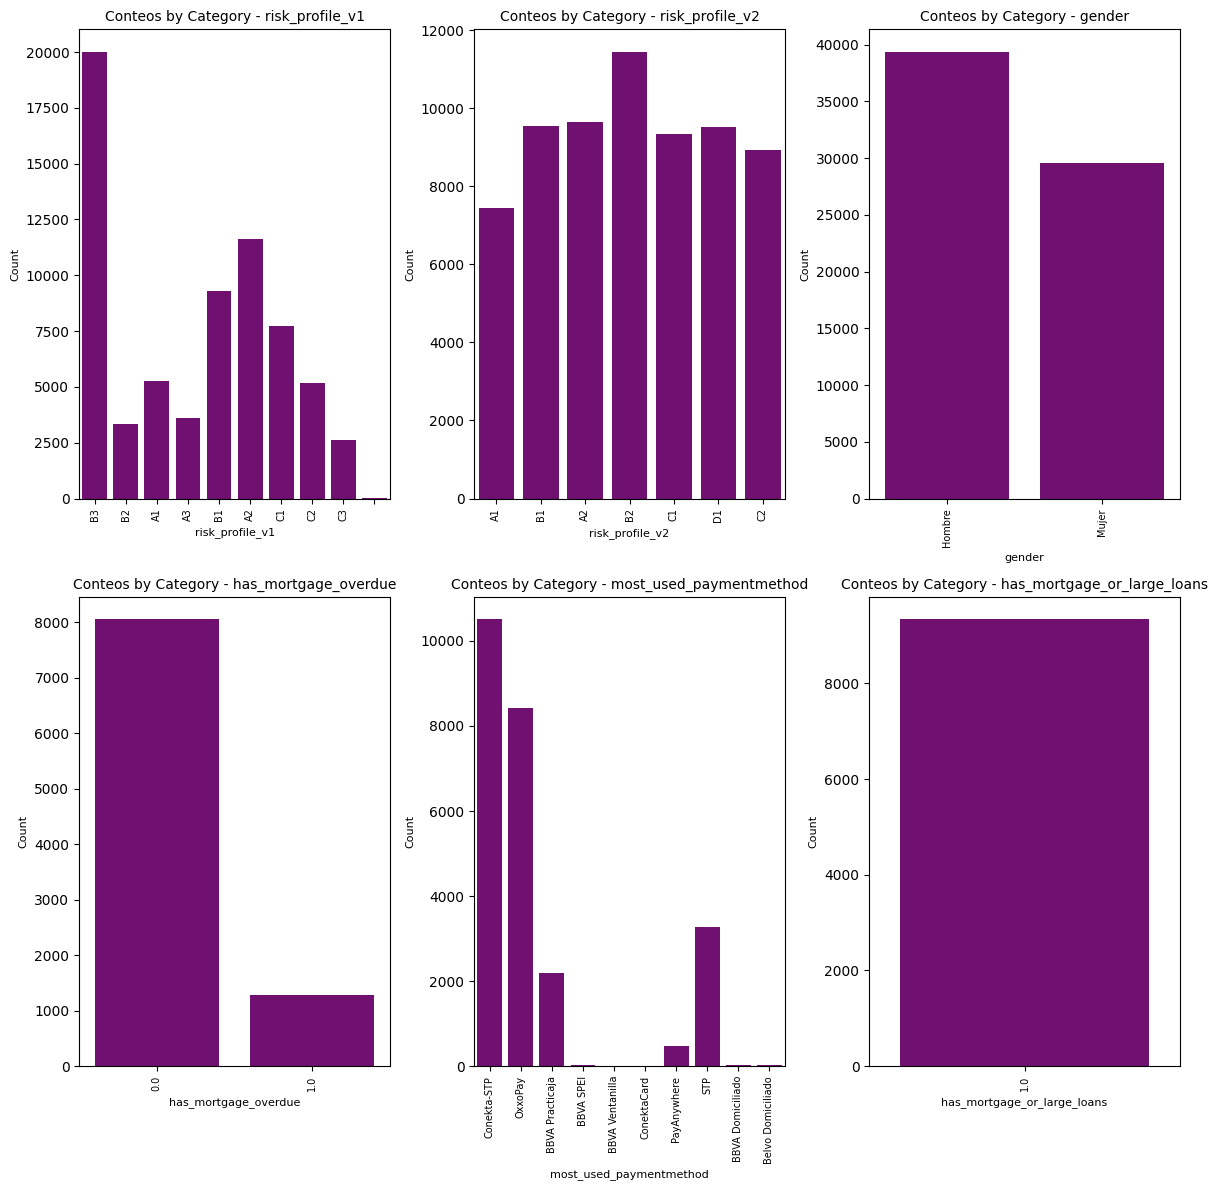

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns

n_cols = 3
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))
axes = axes.flatten()

# Plot each categorical feature in the grid
for i, col in enumerate(df_categoric):
    sns.countplot(data=df_categoric, x=col, ax=axes[i], color='purple')
    axes[i].set_title(f'Conteos by Category - {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Count', fontsize=8)
    axes[i].tick_params(axis='x', rotation=90, labelsize=7)

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# <font color='#8789ed' face='Tahoma' size=5>Análisis de variables correlacionadas, entendimiento y selección</font> 

#### <font color='#b33b3b' face='Monaco' size=5>max_overdue vs days_of_worst_overdue</font> 

In [225]:
df_fc = df[['idobservation', 'id_userv3','max_overdue','days_of_worst_overdue']][(df['num_atrato_credits']==1)&(~df['max_overdue'].isna())]
df_fc['diff']=df_fc['max_overdue']-df_fc['days_of_worst_overdue']
df_fc.describe()

,id_userv3,max_overdue,days_of_worst_overdue,diff
count,27812.000000,27812.000000,27812.000000,27812.0
mean,259289.051381,21.272976,21.272976,0.0
std,173486.670813,27.548616,27.548616,0.0
min,70.000000,1.000000,1.000000,0.0
25%,109834.500000,4.000000,4.000000,0.0
50%,247641.000000,13.000000,13.000000,0.0
75%,388748.250000,29.000000,29.000000,0.0
max,687937.000000,473.000000,473.000000,0.0


In [226]:
df[df['idobservation'].isin(df_fc[df_fc['diff']<0]['idobservation'].to_list())][['id_userv3','payment_history','max_overdue','days_of_worst_overdue']]

,id_userv3,payment_history,max_overdue,days_of_worst_overdue


Revisar los 129 casos donde son diferentes (TEORÍA, MÁS DE UN CRÉDITO AL MISMO TIEMPO), por lo demás quedarse con **days_of_worst_overdue**

#### <font color='#b33b3b' face='Monaco' size=5>current_debt vs pct_credit_maturity</font>

In [227]:
df_sc = df[['idobservation','current_debt','pct_credit_maturity']]
df_sc

,idobservation,current_debt,pct_credit_maturity
0,3649-12,0.656,0.344
1,6154-9,0.707,0.293
2,9411-2,NaN,NaN
3,9411-3,0.971,0.029
4,9411-12,0.910,0.090
...,...,...,...
68938,1784040-2,0.690,0.310
68939,1798971-1,0.917,0.083
68940,1808066-1,0.861,0.139
68941,1829021-1,NaN,NaN


Parece que al sumarlas da 1, por lo que son complementarias, hacemos la comprobación.

In [228]:
df_sc['sum_pct'] = df_sc['current_debt'] + df_sc['pct_credit_maturity']
df_sc['sum_pct'].describe()

/tmp/ipykernel_46742/1783838561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc['sum_pct'] = df_sc['current_debt'] + df_sc['pct_credit_maturity']


count    65297.000000
mean         1.000001
std          0.000030
min          0.999000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.001000
Name: sum_pct, dtype: float64

SELECCIÓN :  tienen la misma correlación, quitarla del modelo, puede usarse para la segmentación final de los clientes

#### <font color='#b33b3b' face='Monaco' size=5>granted_credit_amount vs max_overdue_amount vs monthly_payment</font>

In [229]:
df_tc = df[['idobservation','granted_credit_amount', 'max_overdue_amount','montlhy_payment']]
df_tc = df_tc[~df_tc['max_overdue_amount'].isna()]
df_tc

,idobservation,granted_credit_amount,max_overdue_amount,montlhy_payment
0,3649-12,7500.0,841.654671,692.327335
1,6154-9,6000.0,465.000000,461.462078
3,9411-3,9000.0,528.473374,1056.946749
4,9411-12,9000.0,528.473374,1056.946749
5,9411-10,9000.0,528.473374,1056.946749
...,...,...,...,...
68931,1759140-4,15000.0,1076.990000,2153.980000
68932,1759866-1,2000.0,1113.000000,813.210000
68933,1762547-4,12400.0,2430.000000,4860.020000
68937,1778726-3,3000.0,534.100000,534.100000


In [230]:
df_tc['max_overdue_to_monthly_payment_ratio'] = df_tc['max_overdue_amount']/df_tc['montlhy_payment']
df_tc['max_overdue_to_monthly_payment_ratio'].describe()

count    47772.000000
mean         1.058484
std          0.255826
min          0.054163
25%          1.000000
50%          1.056115
75%          1.164677
max          9.881344
Name: max_overdue_to_monthly_payment_ratio, dtype: float64

In [231]:
df_tc[df_tc['max_overdue_to_monthly_payment_ratio']<1].describe()

,granted_credit_amount,max_overdue_amount,montlhy_payment,max_overdue_to_monthly_payment_ratio
count,12021.000000,12021.000000,12021.000000,12021.000000
mean,13361.528301,1318.069835,1782.731555,0.786560
std,11951.291731,1041.869272,1410.068627,0.219011
min,948.000000,83.000000,165.380000,0.054163
25%,5770.000000,703.000000,918.650000,0.585005
50%,10000.000000,1080.990000,1427.320000,0.838082
75%,16600.000000,1602.400000,2215.700000,0.999455
max,200000.000000,22645.300000,36938.950000,1.000000


La mayoría de las personas deben 1 mensualidad, pero hay gente que debe menos

SUGERENCIA: Usar monto del préstamo para segmentar o el pago mensual.

NOTA: Recordar que los clientes a veces pagan en cuotas una mensualidad, por la que si deben haber casos donde el max_overdue amount sea distinto de la cuota mensual. Quizá usar ratio en lugar de valores por separado

#### <font color='#b33b3b' face='Monaco' size=5>historical_overdue_atrato_credits vs num_atrato_credits

 num_atrato_credits</font>

In [232]:
df['num_atrato_credits'].value_counts(normalize=True)*100

num_atrato_credits
1.0     59.165046
2.0     23.413240
3.0     10.421685
4.0      4.199437
5.0      1.838523
6.0      0.593493
7.0      0.235076
8.0      0.084163
10.0     0.023217
9.0      0.018864
15.0     0.002902
11.0     0.002902
12.0     0.001451
Name: proportion, dtype: float64

In [233]:
df_cc = df[['num_atrato_credits','historical_overdue_atrato_credits']]
df_cc['diff'] = df_cc['num_atrato_credits']-df_cc['historical_overdue_atrato_credits']
df_cc[df_cc['diff']==0].shape[0]/df.shape[0]*100

/tmp/ipykernel_46742/2997433811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc['diff'] = df_cc['num_atrato_credits']-df_cc['historical_overdue_atrato_credits']


88.18299174680533

El 93 % de la población se ha atrasado en todos sus créditos, pueden no haber llegado a un bucket de mora de cobranza.

Quizá hacer un ratio o eliminarla del modelo

#### <font color='#b33b3b' face='Monaco' size=5>paid_late_comission_amount vs pending_late_comission </font>

Por definición son conceptos diferentes, pueden estar correlacionadas debido a que son múltiplos de 300 amnbas variables. Una cosa es cuantas comisiones debe y cuántas ha pagado, puede compararse vs el número de veces que se ha atrasado para ver el porcentaje de comisiones ha pagado.